# **EVALUATION OF INITIALIZATION BIAS IN SIMULATION OUTPUT, COMPARING SCHRUBEN-BASED METHODS**

## *Elisabetta Roviera*  
### *Student ID: s328422*  
### *21 February 2025*

## **Abstract**
<p style="text-align: justify;">
This study investigates the detection of initialization bias in simulation models through the application of three statistical tests: the <code>detect_initialization_bias</code> method, the <code>test_initialization_bias</code> method, and a suite of <code>transient_mean_test</code> (BM, Area, Maximum, BM+Area, BM+Maximum). Each test is applied to two benchmark examples derived from the papers to validate its correctness. Finally, a conclusive example is introduced to evaluate the overall performance of the tests in a real-world scenario. The results demonstrate that all three methods are effective in detecting initialization bias when present, while also correctly identifying cases where no bias exists. The final example confirms the robustness of the methods, as they consistently indicate an absence of bias in a properly initialized simulation. These findings highlight the reliability and practical utility of these tests in assessing initialization effects, ensuring that simulation outputs are free from transient distortions due to improper initial conditions.
</p>

## **Table of Contents**

1. Introduction
2. Detecting Initialization Bias in Simulation Output
3. Optimal Tests for Initialization Bias in Simulation Output
4. Tests for Transient Means in Simulated Time Series  
5. Final Example
6. References

### Import

<p style="text-align: justify;">
This section delineates the packages that are necessary for the effective execution of the code. Furthermore, a random seed has been initialised with the objective of ensuring the reproducibility of all results.
</p>

<p style="text-align: justify;">
<code>Requirements.</code> The following packages are required to reproduce the results of this notebook:
</p>

- numpy
- scipy
- statsmodels
- matplotlib
- time
- heapq
- math

In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import f, kstwobign, t
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import heapq
from math import sqrt

np.random.seed(328422) # For replicability of results 

## Introduction
<p style="text-align: justify;">
    Initialization bias in simulation models refers to the systematic distortion in early-stage outputs due to the arbitrary selection of initial conditions. This bias is particularly problematic in steady-state simulations, where the goal is to analyze long-run system behavior rather than transient effects. When a simulation starts far from its true steady-state, early observations may not be representative of the system's actual performance. If not properly accounted for, this bias can lead to incorrect conclusions and unreliable decision-making. Consequently, detecting and mitigating initialization bias is a crucial step in simulation analysis, particularly in fields such as operations research, manufacturing, and supply chain optimization.
</p>
<p style="text-align: justify;">
    To address this issue, several statistical tests have been developed to assess whether a simulation has reached steady-state. In this study, I explore three key methods:
</p>

<ul style="text-align: justify;">
    <li><b>Detect Initialization Bias Method</b> – This test examines the presence of initialization bias by analyzing the autocorrelation structure of the simulation data. A significant autocorrelation pattern suggests the presence of transient effects, whereas a lack of autocorrelation indicates a properly initialized system.</li>
    <li><b>Test Initialization Bias Method</b> – This test employs statistical hypothesis testing to determine whether the early observations in a simulation significantly deviate from the expected steady-state mean. If the test statistic exceeds a critical threshold, the null hypothesis of no initialization bias is rejected. Otherwise, it is assumed that the simulation has reached a stable state.</li>
    <li><b>Transient Mean Tests (BM, Area, Maximum, BM+Area, BM+Maximum)</b> – These tests evaluate initialization bias by comparing different metrics of transient behavior. For example, the BM test focuses on detecting mean shifts, the BM+Area test assesses cumulative deviations from the steady-state mean, and the BM+Maximum test analyzes the maximum observed deviation. Together, these methods provide a comprehensive assessment of initialization effects.</li>
</ul>
<p style="text-align: justify;">
    To validate these tests, they were implemented and applied to two benchmark examples taken from the literature.  These examples serve as controlled cases where the presence or absence of initialization bias is well understood. By comparing the test outcomes against known results, the correctness and reliability of the implementations can be ensured.
</p>
<p style="text-align: justify;">
    After confirming the accuracy of the tests, they were applied to a final, conclusive example designed to assess the overall effectiveness of the methods in a real-world scenario. This example features two simulations, one with bias and one without. The results consistently indicate an absence of bias across all tests, for the second one. The final example demonstrates that these statistical methods are not only capable of detecting bias when it exists, and what happened for the first simulation, but also effective in verifying cases where bias is absent.
</p>
<p style="text-align: justify;">
    Overall, this study highlights the importance of initialization bias detection in simulation modeling. The tests applied provide a rigorous framework for ensuring that simulation outputs are not distorted by transient effects, leading to more reliable and accurate conclusions.
</p>

## Detecting Initialization Bias in Simulation Output

<p style="text-align: justify;">
Initialization bias arises in simulation output when the system is started from non‐representative initial conditions, which can distort estimates of steady‐state performance. The method described in this paper provides a general, statistically rigorous approach to detect such bias in the average of a simulation output series. By transforming the output into a standardized test sequence that separates the deterministic “signal” (i.e., the potential bias) from the stochastic “noise,” the method enables a comparison with the well‐known properties of a Brownian bridge process. This comparison serves as the basis for a hypothesis test: under the null hypothesis of no bias, the standardized sequence should behave like a Brownian bridge. Significant deviations, especially in the form of a pronounced maximum in the early part of the run, indicate the presence of initialization bias.
</p>

<h4 style="text-align: justify;">Overview of the Initialization Bias Detection Method</h4>

<p style="text-align: justify;">
The present paper proposes a general approach to detecting initialization bias in the average of a series of simulation outputs, rather than its management. The central idea is to transform the output series into a standardized test sequence that can be compared with a known stochastic limit process. The output of a simulation may be expressed as a continuous stochastic process over time, in which each observed data point is comprised of a deterministic component (reflecting possible bias) and a stochastic component. It is hypothesized that the stochastic component is stationary and satisfies the mixing condition, specifically the <em>phi-mixing property</em>, which ensures that events far apart in time are nearly independent. This property is essential for guaranteeing that the stochastic noise does not introduce long-term dependencies that could obscure the detection of bias.
</p>

<p style="text-align: justify;">
The initialization bias is detected by transforming the simulation output into a sequence of standardized partial sums. In this process, the overall output series is first converted into partial sums that highlight deviations from the overall average, thereby isolating the deterministic bias (the “signal”) from the random fluctuations (the “noise”). This standardized sequence is then compared with a Brownian bridge, a conditioned form of Brownian motion that is forced to return to zero at the end of the unit interval. The Brownian bridge’s characteristic covariance structure (with zero variance at the endpoints and controlled fluctuations in between) makes it particularly suitable for detecting systematic deviations caused by initialization bias.
</p>

<p style="text-align: justify;">
The detection procedure focuses on the maximum deviation of the standardized test sequence from zero. Specifically, the test examines the quantity
</p>

<p style="text-align: justify; text-align: center;">
$$ \max_{1 \le k \le n} \left\{ \frac{k\, S_n(k)}{\sqrt{n}} \right\}, $$
</p>

<p style="text-align: justify;">
where $ S_n(k) $ denotes the partial sum difference between the overall average $ Y_n $ and the average of the first $ k $ observations (i.e., $ S_n(k) = Y_n - Y_k $). A statistical value, reflecting both the magnitude and the location of this maximum deviation, is then calculated and compared with critical values derived from the $ F $-distribution with 3 and $ \nu $ degrees of freedom. In practice, a one-tailed test is used to account for the anticipated direction of bias (positive or negative), which improves the test’s sensitivity.
</p>

<p style="text-align: justify;">
The method has been validated both theoretically and empirically across various simulation models. Although it does not directly correct for bias, it provides a diagnostic tool that can prompt corrective actions, such as extending the simulation run length or discarding an initial portion of the data, to mitigate the impact of initialization bias.
</p>

<h4 style="text-align: justify;">Algorithm for Detecting Initialization Bias</h4>

<ol style="text-align: justify;">
  <li>
    <strong>Find the Global Maximum.</strong>  
    Determine $ \hat{s} $, the global maximum of the normalized partial sums,
    <br>
    $$ \left\{ \frac{k\, S_n(k)}{\sqrt{n}} \right\}, \quad k = 1, \dots, n, $$
    and record its location $ \hat{k} $.
  </li>

  <li>
    <strong>Estimate the Variance.</strong>  
    Compute the variance $ \hat{\sigma}^2 $ using the residual variance from an autoregressive model of order $ p $ (AR($ p $)) fitted to the latter part of the output:
    <br>
    $$ \hat{\sigma}^2 = \hat{\sigma}_\epsilon^2 \left(1 - \hat{\phi}_1 - \hat{\phi}_2 - \dots - \hat{\phi}_p \right)^{-2}. $$
  </li>

  <li>
    <strong>Compute the Degrees of Freedom.</strong>  
    Estimate the degrees of freedom $ \nu $ as follows:
    <br>
    $$ \nu = \frac{n\, \hat{\sigma}_\epsilon}{2\, \hat{\sigma} \left(p - \sum_{i=1}^{p} (p - 2i) \hat{\phi}_i\right)}. $$
  </li>

  <li>
    <strong>Calculate the Test Statistic.</strong>  
    Set $ \hat{t} = \hat{k} / n $ and compute
    <br>
    $$ \hat{h} = \frac{\hat{s}^2}{3\, \hat{\sigma}^2\, \hat{t}\,(1 - \hat{t})}. $$
  </li>

  <li>
    <strong>Determine the Significance Level.</strong>  
    Compute the p-value $ \hat{\alpha} $ using the upper tail of the $ F $-distribution:
    <br>
    $$ \hat{\alpha} = \bar{F}_{3,\nu}(\hat{h}), $$
    where $ \bar{F}_{3,\nu}(\cdot) $ denotes the upper tail probability for an $ F $-variates with 3 and $ \nu $ degrees of freedom.
  </li>

  <li>
    <strong>Decision Rule (Optional).</strong>  
    Reject the null hypothesis of no negative bias if $ \hat{\alpha} < \alpha $, where $ \alpha $ is the predefined significance level.
  </li>
</ol>

#### Auxiliary functions
<p style="text-align: justify;">
Three functions have been implemented for the analysis of time series and the evaluation of the correctness of the autoregressive model. The <code>estimated_variance</code> function estimates the overall variance of the series by applying an AR model of order <em>p</em>. It extracts the AR coefficients, calculates the variance of the residual error, and checks the stability of the model (i.e., ensuring that the sum of the coefficients is less than 1) before determining the overall variance of the series. The <code>plot_acf_pacf</code> function facilitates the graphical representation of the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF), which are instrumental in identifying the temporal properties and determining the appropriate model order. Finally, the <code>correct_p</code> function verifies the appropriateness of the selected <em>p</em>-order by performing the Ljung-Box test on the AR model residuals, returning a Boolean value indicating whether the hypothesis of no significant autocorrelation is fulfilled. 
</p>

In [2]:
## ESTIMATED VARIANCE FUNCTION
def estimated_variance(data, p):
    """
    Estimates the variance of a time series using an Autoregressive (AR) model
    
    Args:
    data (array-like): The time series data
    p (int): The order (number of lags) of the AR model
    
    Returns:
    tuple: A tuple containing the estimated variance (sigma_squared), the estimated error variance (sigma_epsilon_squared), and the AR coefficients (phi)
    
    Print:
    ValueError: If the estimated AR model is not stable (|phi_sum| >= 1) or if the sum of the AR coefficients is too close to 1
    """
    model = AutoReg(data, lags=p).fit()
    
    # Estimated AR coefficients (phi_1, phi_2, ..., phi_p)
    # These represent the weights of the past values in the AR model
    phi = model.params[1:] # Skip the intercept term
    phi_sum = np.sum(phi) 
    
    # Estimated variance of the error term (sigma_epsilon^2)
    # This represents the variability of the data that is not explained by the AR model
    sigma_epsilon_squared = model.sigma2
    
    # Calculate the variance of the time series (sigma^2)
    # This is the total variability of the data, including the part explained by the AR model
    sigma_squared = sigma_epsilon_squared * (1 / (1 - phi_sum))**2
    
    # Check for model stability. A stable AR model requires |phi_sum| < 1
    if np.abs(phi_sum) >= 1:
        print("The estimated AR model is not stable (|phi_sum| >= 1).")
    
    # Check if the sum of the coefficients is too close to 1, which would make the variance calculation unstable
    if np.isclose(1 - phi_sum, 0):
        print("The sum of the phi coefficients is too close to 1, making the calculation of sigma^2 unstable.")
    
    return sigma_squared, sigma_epsilon_squared, phi

## PLOT ACF and PACF
def plot_acf_pacf(data, lags=20):
    """
    Plots ACF and PACF of a time series

    Args:
        data (array-like): The time series data
        lags (int, optional): The maximum number of lags to display. Defaults to 20
    """
    # Plot ACF and PACF
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    plot_acf(data, ax=axes[0], lags=lags) 
    plot_pacf(data, ax=axes[1], lags=lags, method='ywm')
    axes[0].set_title('Autocorrelation Function (ACF)')
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    plt.show()

## CORRECTNESS OF P
def correct_p(data, p, lags=[5, 10, 15]):
    """
    Evaluates if the value of p is appropriate for an AR(p) model

    Args:
        data (array-like): The time series data
        p (int): The order of the AR model
        lags (list, optional): Lags to test in the Ljung-Box test. Defaults to [5, 10, 15]

    Returns:
        bool: True if the value of p is correct, False otherwise
    """
    try:
        # Fit the AR model
        model = AutoReg(data, lags=p).fit()
        residuals = model.resid

        # Ljung-Box test for autocorrelation in residuals
        ljungbox_result = acorr_ljungbox(residuals, lags=lags, return_df=True)
        print(ljungbox_result) 

        # Check if there is significant autocorrelation at any of the lags
        if (ljungbox_result['lb_pvalue'] < 0.05).any():
            return False  # Autocorrelation detected, p is not correct
        else:
            return True    # No autocorrelation detected, p is correct

    except Exception as e:
        print(f"Error fitting AR({p}) model: {e}")
        return False

#### Main Function
<p style="text-align: justify;">
The <code>detect_initialization_bias</code> function analyzes a simulation output time series to determine if initialization bias is present. It starts by computing the standardized partial sums, which quantify deviations from the overall mean. The maximum of these scaled deviations is identified, and its location is used to calculate a normalized time value. The function then estimates the variance of the series using an autoregressive model, ensuring that the model is stable. This variance, along with the AR coefficients, is used to calculate the degrees of freedom. Next, a test statistic is derived from the maximum deviation, and the corresponding p-value is computed using the upper tail of an F-distribution. Finally, the function compares the p-value to a specified significance level and returns both the p-value and a message indicating whether there is statistically significant evidence of initialization bias.
</p>

<p style="text-align: justify;">
The <strong>control over the margin of $ t $</strong> (i.e., verifying that $ t^* $ is not too close to 0 or 1)  is important for several reasons:
</p>

<ol style="text-align: justify;">
  <li>
    <strong>Numerical Stability.</strong>
    The test statistic is calculated using the formula
    <br>
    $$
    \hat{h} = \frac{\hat{s}^2}{3\,\hat{\sigma}^2\,\hat{t}(1-\hat{t})}.
    $$
    If $ \hat{t} $ (the normalized position of the maximum) is too close to 0 or 1, the product $ \hat{t}(1-\hat{t}) $ becomes very small. This can cause extremely high or unstable values for $ \hat{h} $, leading to unreliable estimates and possible numerical errors in the calculation of the p-value.
  </li>

  <li>
    <strong>Asymptotic Validity.</strong>
    The test is based on a comparison with an asymptotic distribution derived from the Brownian bridge, whose validity is ensured in the "heart" of the unit interval. Near the extremes, the asymptotic properties may no longer be adequate, compromising the accuracy of the test.
  </li>

  <li>
    <strong>Test Robustness.</strong>
    In simulations with short runs or in special cases where the maximum deviation occurs very early or very late, the control ensures that the calculation is carried out in a region of the interval where the normalization is stable and the comparison with the theory (the $ F $ distribution) is reliable.
  </li>
</ol>

<p style="text-align: justify;">
The introduction of this practical control stems from the need to make the algorithm robust and reliable even under non-ideal conditions.
Although in a purely theoretical analysis the control over the margin of $ t $ could be neglected, in practice it is fundamental to ensure that the initialization bias detection test is robust and that the results are reliably interpretable.
</p>

<p style="text-align: justify;">
The <strong>null hypothesis (H0)</strong> posits the absence of initialisation bias in the simulation data, thereby suggesting that the initial data does not exert a significant influence on the subsequent results. Conversely, if the null hypothesis is rejected ($p\_value < \alpha$), it is deduced that there exists statistically significant evidence of initialisation bias. The data suggest that the initial simulation values have a substantial impact on the results, indicating the necessity for a longer 'warm-up' period or alternative strategies to mitigate this effect.
Conversely, if the null hypothesis is not rejected ($p\_value ≥ \alpha$), it can be deduced that the evidence for initialisation bias is insufficient to reach a conclusive determination. However, it is important to note that this does not imply the complete absence of bias; it may be present but is not significant enough to be detected at the chosen significance level ($\alpha$).
</p>

In [3]:
def detect_initialization_bias(data, p, alpha=0.05):
    """
    Implementation of the test to detect initialization bias in a series of simulation output

    Parameters:
    - data: array-like, time series of the simulation output data
    - p: int, order of the autoregressive model used for variance estimation
    - alpha: float, significance level for the test (default 0.05)

    Returns:
    - result: str, the result of the test
    - p_value: float, the p-value of the test

    Raises:
    - TypeError: if data is not a list or numpy array
    - TypeError: if p is not an integer
    - ValueError: if p is greater than the length of data

    """

    if not isinstance(data, list) and not isinstance(data, np.ndarray):
        raise TypeError("Data must be a list or numpy array")

    if not isinstance(p, int):
        raise TypeError("p must be an integer")

    if p > len(data):
        raise ValueError("p must be less than or equal to the length of data")

    n = len(data)
    mean_output = np.mean(data)

    # Calculation of standardized partial sums
    partial_sums = np.array([mean_output - (np.sum(data[:k])/k) for k in range(1, n+1)])
    scaled_sums = np.array(list(k*partial_sums[k-1] / np.sqrt(n) for k in range(1, n+1)))

    # Calculation of the maximum of the standardized sequence
    s_star = np.max(scaled_sums)
    k_star = np.argmax(scaled_sums) + 1

    # Calculation of the variance
    sigma_squared, sigma_epsilon_squared, phi = estimated_variance(data, p)

    # Calculation of the degrees of freedom
    degrees_freedom = (n*sqrt(sigma_epsilon_squared))/(2*sqrt(sigma_squared)*(p-sum((p - 2 * i) * phi[i-1] for i in range(1, p + 1))))
    t_star = k_star / n

    epsilon = 1 / n  # Minimum threshold to avoid problems at the edges
    if t_star < epsilon or t_star > 1 - epsilon:
        t_star = np.clip(t_star, epsilon, 1 - epsilon)  # t_star put in [eps, 1-eps]
        print(f"t_star={t_star} too close to the edges, it could compromise the test.")

    # Calculation of the test statistic
    h_star = (s_star*s_star)/(3*sigma_squared*t_star*(1-t_star))

    # Calculation of the p-value using the F distribution
    p_value = 1 - f.cdf(h_star, dfn=3, dfd=degrees_freedom)  # Upper tail probability

    # Test decision: reject or not the null hypothesis?
    decision = p_value < alpha
    if decision:
        result = "The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias"
    else:
        result = "The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination"
    return p_value, result

#### Example 1 - Simulation of a call centre
<p style="text-align: justify;">
This example is a simulation of a call centre's data collection system, analogous to a study by McDaniel (1979). The simulation models the handling of incoming calls and the tracking of the number of calls in the system, whilst also exploring the impact of initialization bias. This bias occurs when the starting state of the simulation (e.g. an empty call centre) unduly influences the early results. The <code>simulate_call_centre</code> function performs multiple simulation runs (25 in this case) under two different initial conditions: starting empty and starting with a random number of calls drawn from the steady-state distribution (simulating a "warm start"). Each run tracks the number of calls after each completed call, for a total of 200 call completions. This setup allows for comparison and testing for initialization bias. 
</p>

In [4]:
def simulate_call_centre(steady_state=False, num_calls=200, num_runs=25):
    """
    Simulates a call center with a given arrival and service rate

    Args:
        steady_state (bool, optional): Whether to start the simulation in a steady state. If True, the initial number of calls is drawn from a Poisson distribution. Defaults to False
        num_calls (int, optional): The total number of calls to simulate in each run. Defaults to 200
        num_runs (int, optional): The number of simulation runs to perform. Defaults to 25

    Returns:
        numpy.ndarray: A NumPy array containing the number of calls in the system for each call and each run. The shape of the array is (num_runs, num_calls)
    """
    all_runs = []

    for _ in range(num_runs):
        calls_in_system = []
        initial_calls = np.random.poisson(10) if steady_state else 0  # Initialize from Poisson if steady state, otherwise 0
        current_calls = initial_calls

        for _ in range(num_calls):
            arrival = np.random.poisson(1)  # Simulate new arrivals (lambda = 1)
            departure = np.random.binomial(current_calls, 0.1)  # Simulate completed calls (probability = 0.1)

            current_calls += arrival - departure
            current_calls = max(0, current_calls)  # Ensure the number of calls is not negative

            calls_in_system.append(current_calls)

        all_runs.append(calls_in_system)

    return np.array(all_runs) 

##### First simulation with bias
<p style="text-align: justify;">
The initial graph <strong>Data with Trend Bias</strong> displays the mean number of system calls during the simulation. It is evident that an initial trend is present, characterised by a rapid increase in the first 50 events, followed by a stabilisation around the mean value (dashed red line). This behaviour suggests the presence of an initialisation bias, as the system commences from an empty state and requires time to reach a steady state.

The <strong>ACF</strong> reveals a pronounced serial dependency between successive values, accompanied by a gradual decline in autocorrelation, suggesting that the process exhibits long memory and is potentially susceptible to initialisation bias. Conversely, the <strong>PACF</strong> demonstrates a notable first peak, indicating the potential adequacy of a low-order autoregressive model, though with the possibility of residual dependencies.

The output of the <strong>Ljung-Box test</strong> provides relatively high p-values for the first lags, suggesting that the null hypothesis of no autocorrelation cannot be rejected initially. However, <strong>the conclusion of the test states that the null hypothesis is rejected, indicating statistical evidence of initialisation bias</strong>. This implies that the initial phase of the simulation has a significant impact on the dynamics of the system.
</p>

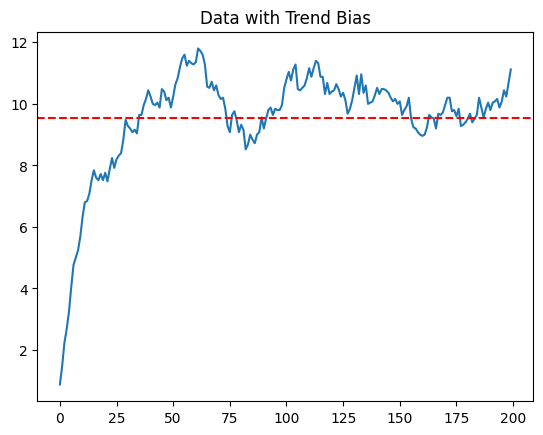

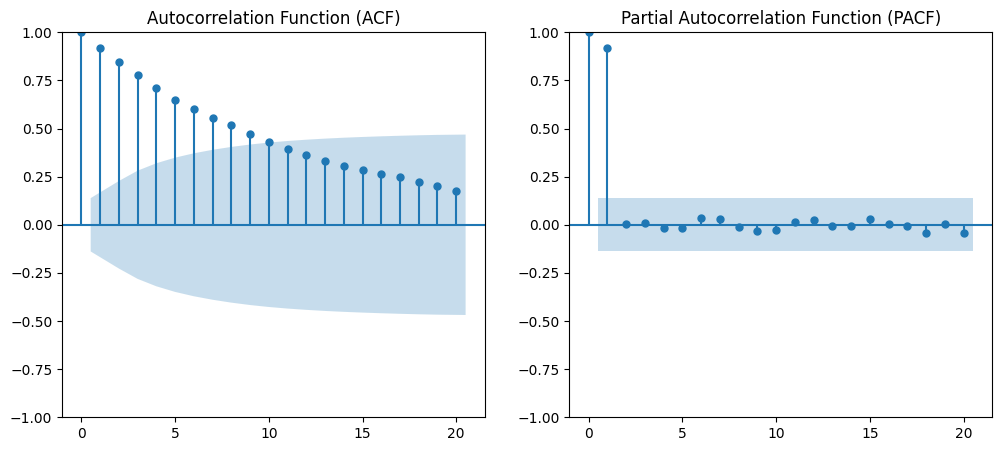

      lb_stat  lb_pvalue
5    2.755136   0.737674
10  14.138583   0.166764
15  20.036277   0.170545
The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias


In [5]:
data_empty = simulate_call_centre(steady_state=False) # Simulate call center data starting with an empty system

# Plot and analyze data with trend bias
plt.plot(data_empty.mean(axis=0)) # Plot the average number of calls across all simulation runs
plt.axhline(data_empty.mean(), color='red', linestyle='--', label='Mean')
plt.title("Data with Trend Bias")
plt.show() 

p = 2  # Order of the Autoregressive (AR) model to be used for variance estimation in the bias test
plot_acf_pacf(data_empty.mean(axis=0), lags=20)

if correct_p(data_empty.mean(axis=0), p): # Check if the chosen 'p' is appropriate for the data
    p_value, result = detect_initialization_bias(data=data_empty.mean(axis=0), p=p, alpha=0.05) 
    print(result) 
else:
    print(f"The chosen AR order (p={p}) is not appropriate for the data with trend bias. Please adjust and try again.") # If 'p' is not suitable

##### Secondo simulation without bias
<p style="text-align: justify;">
The primary graph, <strong>Data without Trend Bias</strong>, pertaining to the simulated data under steady state conditions, demonstrates a trend in the number of calls in the system that is considerably different from that observed in the case with trend bias. It is evident that greater stability is exhibited from the early stages of the simulation, with minor fluctuations around the average value (represented by the dashed red line). This finding indicates that the initialisation from a steady state has effectively mitigated the impact of the initial bias.

The <strong>ACF</strong> in this case demonstrates a less pronounced serial dependence than in the previous case, with a more rapid decrease in autocorrelation, suggesting that the system possesses a shorter 'memory' and that the influence of initialisation is less persistent. The <strong>PACF</strong>, as expected, displays a less pronounced initial peak, indicating that a lower-order autoregressive model might suffice in describing the data.

The outcomes of the <strong>Ljung-Box test</strong>, within the context of this study, demonstrate elevated p-values for all lags that were taken into consideration. This finding indicates that the null hypothesis of the absence of autocorrelation in the residuals of the AR model cannot be refuted. Consequently, <strong>there is an absence of statistical evidence to support the hypothesis of a substantial initialisation bias</strong> in the simulated data under steady state conditions. The hypothesis that initialisation from a steady state significantly reduces the initial bias in the simulated system is thus supported by the analysis of the graphs and the results of the Ljung-Box test.
</p>

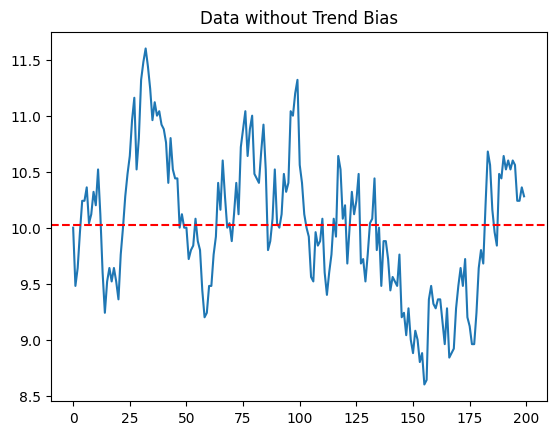

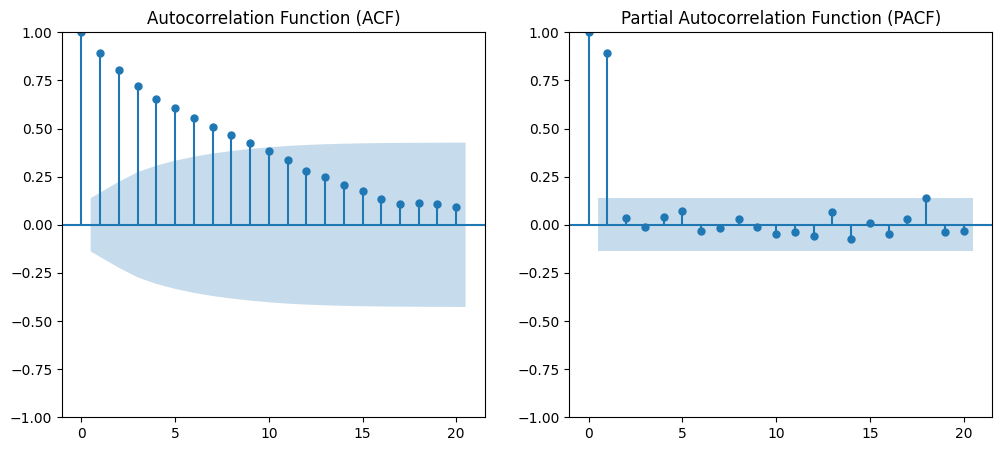

     lb_stat  lb_pvalue
5   1.758072   0.881504
10  2.974911   0.982008
15  5.971921   0.980216
The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination


In [6]:
data_steady = simulate_call_centre(steady_state=True) # Simulate call center data starting in a steady state

# Plot and analyze data without trend bias
plt.plot(data_steady.mean(axis=0)) 
plt.axhline(data_steady.mean(), color='red', linestyle='--', label='Mean')
plt.title("Data without Trend Bias") 
plt.show() 

p = 2  # Order of the Autoregressive (AR) model
plot_acf_pacf(data_steady.mean(axis=0), lags=20) 

if correct_p(data_steady.mean(axis=0), p): # Check if the chosen 'p' is appropriate for this steady-state data
    p_value, result = detect_initialization_bias(data=data_steady.mean(axis=0), p=p, alpha=0.05) 
    print(result) 
else:
    print(f"The chosen AR order (p={p}) is not appropriate for the data without trend bias. Please adjust and try again.") 

#### Example 2 - An Inventory System
<p style="text-align: justify;">
This simulation model is designed to emulate an inventory system for a warehouse storing output from a simplified production facility. The warehouse is characterised by a fixed capacity, and the production line's output rate is twice the demand rate when active. The simulation demonstrates that when the warehouse reaches capacity, production halts. A key feature of the model is the incorporation of random shutdowns governed by a Markov process, thereby introducing a stochastic element to the system's dynamics. The <code>simulate_inventory_run</code> simulates multiple runs, varying the initial inventory level (empty or randomly drawn from the steady-state distribution) to assess the impact of these initial conditions on the observed inventory levels and the effectiveness of statistical tests in detecting initialisation bias.  Each iteration of the simulation is observed for a duration of 200 days, during which the inventory level is recorded on a daily basis.
</p>

In [7]:
def simulate_inventory_run(n_days=200, capacity=100, demand=10, p_working_to_working=0.90, p_shutdown_to_shutdown=0.70, initial_inventory=0, seed=None):
    """
    Simulates a single run of the inventory system for n_days days

    Args:
        n_days (int): Number of days (observations)
        capacity (int): Maximum warehouse capacity
        demand (int): Daily demand (outflow)
        p_working_to_working (float): Probability that the production line remains active if already active
        p_shutdown_to_shutdown (float): Probability that the production line remains in shutdown if already shut down
        initial_inventory (int): Initial inventory level
        seed (int, optional): Seed for random number generation

    Returns:
        numpy.ndarray: Array of size (n_days+1) containing the inventory level (including day 0)
    """
    if seed is not None:
        np.random.seed(seed) 

    # Production state: 1 = working, 0 = shutdown
    production_state = 1  # Start with production active

    # Initialize inventory
    inventory_levels = np.zeros(n_days + 1)  # Initialize array to store inventory levels for each day
    inventory_levels[0] = initial_inventory  # Set initial inventory level

    # Loop for each day
    for day in range(1, n_days + 1):
        current_inventory = inventory_levels[day - 1]  # Get inventory level from the previous day

        # Determine today's production state based on the previous one (Markov process)
        if production_state == 1:
            # If it was working, it stays working with probability p_working_to_working, otherwise it goes to shutdown
            if np.random.rand() > p_working_to_working:  
                production_state = 0  # Production line shuts down
        else:
            # If it was shutdown, it restarts working with probability (1 - p_shutdown_to_shutdown)
            if np.random.rand() > p_shutdown_to_shutdown:  
                production_state = 1  # Production line restarts

        # Calculate the input 
        if production_state == 1 and current_inventory < capacity:
            # If production is active and warehouse is not full, input is twice the demand
            potential_input = 2 * demand  
            # Limit input to not exceed capacity
            input_amount = min(potential_input, capacity - current_inventory)  
        else:
            input_amount = 0  # No input if production is off or warehouse is full

        # The output (demand) is constant, but we cannot withdraw more than we have
        output_amount = min(demand, current_inventory + input_amount) 

        # Update the inventory level
        new_inventory = current_inventory + input_amount - output_amount 
        inventory_levels[day] = new_inventory 

    return inventory_levels  

def approximate_steady_state(n_days=2000, capacity=100, demand=10, p_working_to_working=0.90, p_shutdown_to_shutdown=0.70, seed=None):
    """
    Performs a long simulation to approximate the steady-state inventory level
    Returns the last inventory value as an estimate for initial sampling from the stationary distribution
    """
    inventory_levels = simulate_inventory_run(n_days = n_days,  # Run the simulation for a long time
                                            capacity = capacity,
                                            demand = demand,
                                            p_working_to_working = p_working_to_working,
                                            p_shutdown_to_shutdown = p_shutdown_to_shutdown,
                                            initial_inventory = 0,  # Start with an empty inventory
                                            seed = seed)
    return inventory_levels[-1]  # Return the last inventory level as an approximation of the steady-state level

##### Results of the simulations with and without bias
<p style="text-align: justify;">
The initial graph, <strong>Evolution of Average Inventory Level Over Time</strong>, which illustrates the development of the average inventory level over time, compares two scenarios: one in which the warehouse is initially empty (illustrated in blue) and one in which it is in a steady state (illustrated in orange). In the former scenario, a more pronounced initial increase in the inventory level is observed, suggesting a transitional phase due to the need to fill the empty warehouse. In the latter scenario, the trend is more stable from the beginning, with small fluctuations around the average value. This finding indicates that initialising from a steady state can mitigate the influence of initial bias.
    
The <strong>ACF</strong> and <strong>PACF</strong> graphs for the scenario with initially empty stock demonstrate a substantial serial dependency in the data. The ACF reveals a gradual decline in autocorrelation, suggesting a 'long memory' characteristic of the system. The PACF indicates the potential for a low-order autoregressive pattern, though with the possibility of residual dependencies. The outcomes of the <strong>Ljung-Box test</strong> demonstrate that the null hypothesis of no autocorrelation in the residuals of the AR model cannot be initially rejected; however, the conclusion of the test states that <strong>the null hypothesis is rejected, suggesting statistical evidence of initialisation bias</strong>. This implies that the initial phase of the simulation has a significant impact on the dynamics of the system.

In the case with stock initially in the steady state, the <strong>ACF</strong> and <strong>PACF</strong> graphs show a less pronounced serial dependence. The outcomes of the <strong>Ljung-Box test</strong> demonstrate an <strong>absence of a significant initialisation bias</strong>.
</p>

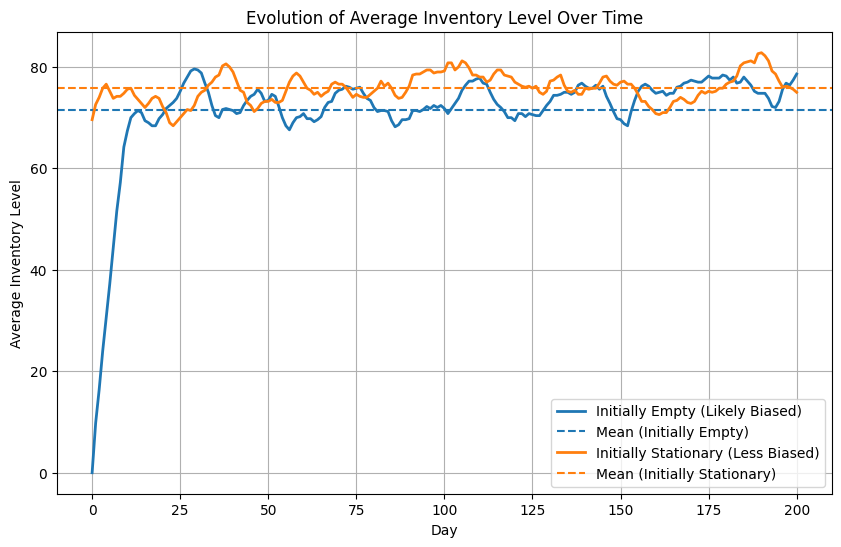

Simulation BLUE - Initially empty


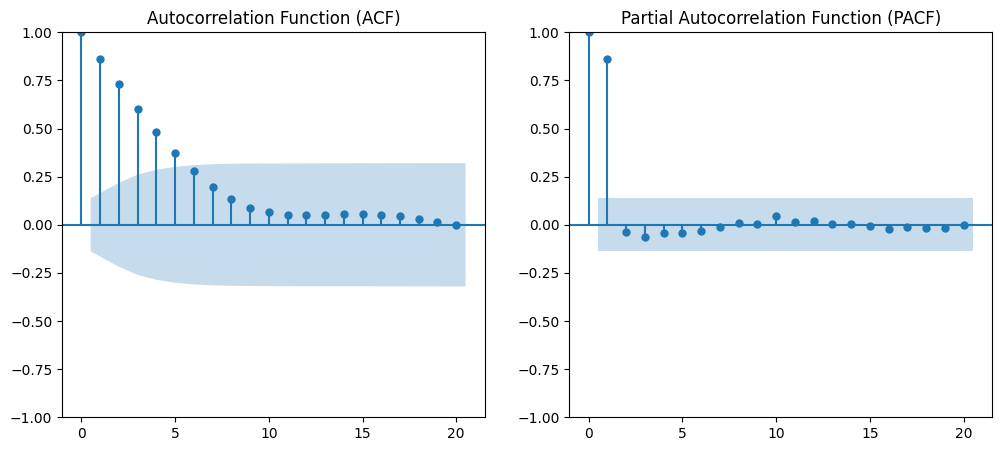

      lb_stat  lb_pvalue
5    1.550472   0.907173
10   5.548442   0.851669
15  11.381845   0.725086
The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias

Simulation ORANGE - Initially stationary


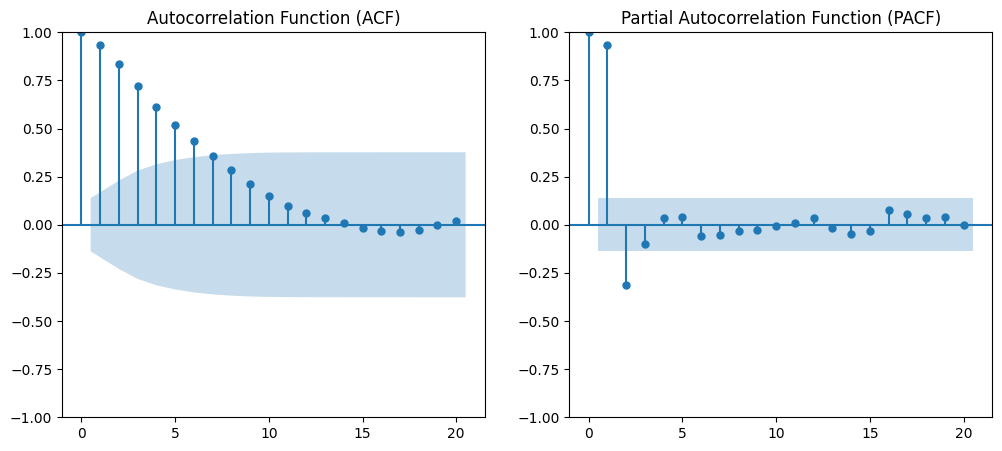

      lb_stat  lb_pvalue
5    0.354102   0.996500
10   2.344697   0.992951
15  12.637764   0.630254
The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination


In [8]:
# General simulation parameters
n_observations = 200  # Number of days (observations) per simulation run
n_runs = 50  # Number of independent simulation runs
capacity = 100  # Maximum warehouse capacity
demand = 10  # Daily demand

# Parameters of the Markov process governing production line state
p_working_to_working = 0.90  # Probability production stays active if it's currently active
p_shutdown_to_shutdown = 0.70  # Probability production stays shutdown if it's currently shutdown

# Two initial inventory scenarios:
# 1. Initially empty warehouse (to show initialization bias)
# 2. Warehouse initially "in steady state" (to show the absence of bias)

# Case 1: Initially empty warehouse
runs_empty = []  
for i in range(n_runs):
    seed = 1000 + i 
    inv_levels = simulate_inventory_run(n_days=n_observations, capacity=capacity, demand=demand,
                                        p_working_to_working=p_working_to_working,
                                        p_shutdown_to_shutdown=p_shutdown_to_shutdown,
                                        initial_inventory=0, seed=seed)
    runs_empty.append(inv_levels)
runs_empty = np.array(runs_empty)  

# Case 2: Warehouse initially in steady state (approximated)
runs_stationary = [] 
for i in range(n_runs):
    seed = 2000 + i 
    # Approximate steady-state inventory level using a long "burn-in" simulation
    init_inventory = approximate_steady_state(n_days=2000, capacity=capacity, demand=demand,
                                                p_working_to_working=p_working_to_working,
                                                p_shutdown_to_shutdown=p_shutdown_to_shutdown, seed=seed)
    inv_levels = simulate_inventory_run(n_days=n_observations, capacity=capacity, demand=demand,
                                        p_working_to_working=p_working_to_working,
                                        p_shutdown_to_shutdown=p_shutdown_to_shutdown,
                                        initial_inventory=init_inventory, seed=seed + 100)  # Slightly change seed for the main run
    runs_stationary.append(inv_levels)
runs_stationary = np.array(runs_stationary) 


days = np.arange(n_observations + 1)  

# Calculate the daily average inventory level for each scenario
mean_empty = np.mean(runs_empty, axis=0)  # Average across all runs for the initially empty case
mean_stationary = np.mean(runs_stationary, axis=0)  # Average across all runs for the steady-state initial case

# Plot the average inventory levels over time for both scenarios
plt.figure(figsize=(10, 6))
line_empty, = plt.plot(days, mean_empty, label='Initially Empty (Likely Biased)', lw=2)
plt.axhline(mean_empty.mean(), color=line_empty.get_color(), linestyle='--', label='Mean (Initially Empty)')  
line_stationary, = plt.plot(days, mean_stationary, label='Initially Stationary (Less Biased)', lw=2)
plt.axhline(mean_stationary.mean(), color=line_stationary.get_color(), linestyle='--', label='Mean (Initially Stationary)') 
plt.xlabel("Day") 
plt.ylabel("Average Inventory Level")  
plt.title("Evolution of Average Inventory Level Over Time") 
plt.legend()  
plt.grid(True)  
plt.show()  

p = 2  # Order of the Autoregressive (AR) model for the initialization bias test

print("Simulation BLUE - Initially empty")
# Analyze and perform the initialization bias test for the initially empty case
plot_acf_pacf(runs_empty.mean(axis=0), lags=20)  
if correct_p(runs_empty.mean(axis=0), p):  
    p_value, result = detect_initialization_bias(data=runs_empty.mean(axis=0), p=p, alpha=0.05)
    print(result)  
else:
    print(f"The chosen AR order (p={p}) is not appropriate for the initially empty data. Please adjust and try again.")

print("\nSimulation ORANGE - Initially stationary")
# Analyze and perform the initialization bias test for the initially stationary case
plot_acf_pacf(runs_stationary.mean(axis=0), lags=20)  
if correct_p(runs_stationary.mean(axis=0), p):  
    p_value, result = detect_initialization_bias(data=runs_stationary.mean(axis=0), p=p, alpha=0.05)
    print(result) 
else:
    print(f"The chosen AR order (p={p}) is not appropriate for the initially stationary data. Please adjust and try again.")

## Optimal Tests for Initialization Bias in Simulation Output

<p style="text-align: justify;">
The paper "Optimal Tests for Initialization Bias in Simulation Output" by Schruben, Singh, and Tierney (1983) introduces a robust statistical test designed to detect initialization bias in simulation output. The method transforms the simulation data into a standardized sequence that isolates a deterministic “signal” (representing potential bias) from the stochastic “noise.” In the absence of bias, this standardized sequence is expected to mimic the behavior of a Brownian bridge.
</p>

<p style="text-align: justify;">
The authors posit that the simulation output can be decomposed into two components: a deterministic part that may embody the initialization bias and a stochastic part that is assumed to be stationary with weak temporal dependence (i.e., satisfying the <em>phi-mixing</em> property). By converting the data into standardized partial sums, systematic deviations from the overall mean become apparent, especially during the early stages of the simulation.
</p>

<h4 style="text-align: justify;">Algorithm for Bias Detection</h4>

<p style="text-align: justify;">
The following algorithm tests for initialization bias in simulation output using a modified Brownian bridge approach that accounts for autocorrelation by estimating an effective sample size via an AR(p) model. Given a time series \( Y_1, Y_2, \dots, Y_n \), the procedure is as follows.
</p>

<h4 style="text-align: justify;">Step 1: Data Preprocessing and Stationarity Determination</h4>

<ol style="text-align: justify;">
  <li>
    <strong>Effective Sample Size.</strong> If a stationary start index is not provided, estimate the effective sample size \( n_{\text{eff}} \) using an AR(p) model.
  </li>
  <li>
    <strong>Stationary Segment.</strong> Define the stationary portion of the data as \( \{Y_{n_{\text{eff}}+1}, \dots, Y_n\} \). Compute the stationary mean
    <p style="text-align: center;">
      $$ \bar{Y}_{\text{stationary}} = \frac{1}{n - n_{\text{eff}}} \sum_{i=n_{\text{eff}}+1}^{n} Y_i, $$
    </p>
    and the corresponding standard deviation \( \sigma_{\text{stationary}} \) (using an unbiased estimate with ddof=1).
  </li>
</ol>

<h4 style="text-align: justify;">Step 2: Residuals and Modified Brownian Bridge Construction</h4>

<ol style="text-align: justify;">
  <li>
    <strong>Residual Calculation.</strong> Compute the residuals for each observation:
    <p style="text-align: center;">
      $$ \text{residuals}_i = Y_i - \bar{Y}_{\text{stationary}}, \quad i = 1, \dots, n. $$
    </p>
  </li>
  <li>
    <strong>Cumulative Sum.</strong> Calculate the cumulative sum of residuals:
    <p style="text-align: center;">
      $$ S(k) = \sum_{i=1}^{k} \text{residuals}_i, \quad S(0) = 0, \quad k = 0, 1, \dots, n. $$
    </p>
  </li>
  <li>
    <strong>Brownian Bridge.</strong> Construct the modified Brownian bridge:
    <p style="text-align: center;">
      $$ B(k) = \frac{S(k) - \frac{k}{n}\, S(n)}{\sigma_{\text{stationary}} \sqrt{n_{\text{eff}}}}, \quad k = 0, 1, \dots, n. $$
    </p>
  </li>
</ol>

<h4 style="text-align: justify;">Step 3: Test Statistic Calculation</h4>

<ol style="text-align: justify;">
  <li>
    <strong>Overall Statistics.</strong> Let
    <p style="text-align: center;">
      $$ \bar{Y}_n = \frac{1}{n}\sum_{i=1}^{n} Y_i \quad \text{and} \quad \sigma_{\text{sample}} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(Y_i - \bar{Y}_n)^2}. $$
    </p>
  </li>
  <li>
    <strong>Aggregated Deviation.</strong> For each \( k \) (from 1 to \( n \)), define \( \bar{Y}_k \) as the mean of the first \( k \) observations.
  </li>
  <li>
    <strong>Test Statistic.</strong> The test statistic for detecting negative bias (with the sign reversed for positive bias) is computed as:
    <p style="text-align: center;">
      $$ T = \frac{\sqrt{45}}{n^{3/2}\, \sigma_{\text{sample}}} \sum_{k=1}^{n} \left(1 - \frac{k}{n}\right) k \left(\bar{Y}_n - \bar{Y}_k\right). $$
    </p>
  </li>
</ol>

<h4 style="text-align: justify;">Step 4: Critical Value and Decision Rule</h4>

<ol style="text-align: justify;">
  <li>
    <strong>Critical Value.</strong> Obtain the critical value from the Student’s t-distribution:
    <p style="text-align: center;">
      $$ t_{\text{critical}} = t.ppf(1-\alpha,\, \text{df} = n_{\text{eff}}), $$
    </p>
    where \( \alpha \) is the significance level.
  </li>
  <li>
    <strong>Decision.</strong> Compare the test statistic \( T \) with \( t_{\text{critical}} \). If \( T > t_{\text{critical}} \) (or the sign is reversed for testing positive bias), reject the null hypothesis of no initialization bias; otherwise, do not reject it.
  </li>
</ol>

#### Auxiliary functions
<p style="text-align: justify;">
The function <code>estimate_d_eff</code> calculates the actual number of independent observations in a stationary time series. In order to do this, it fits an autoregressive (AR) model of maximum order defined by max_autoregressive_order (default=5) to the data set. It then extracts the autoregressive coefficients (excluding the intercept) and applies the formula:

$$d\_eff = \frac{n}{1 + 2 \sum |\text{coefficients}|},$$

where *n* denotes the length of the series. The result is rounded down and incremented by 1, ensuring a minimum of 1. This function estimates the effective sample size, taking into account the serial dependency in the data.
</p>

In [9]:
def estimate_d_eff(stationary_time_series, max_autoregressive_order=5):
    """
    Estimates the effective number of independent observations for an AR(p) model

    Args:
        stationary_time_series (array-like): The stationary time series data
        max_autoregressive_order (int, optional): The maximum order of the AR model to consider. Defaults to 5

    Returns:
        int: The estimated effective sample size. It returns at least 1, and takes the floor + 1 of the calculation
    """
    # Fit an autoregressive model of order up to max_autoregressive_order
    ar_model = AutoReg(stationary_time_series, lags=max_autoregressive_order, old_names=False).fit()
    
    # Extract the autoregressive coefficients (excluding the intercept)
    autoregressive_coefficients = ar_model.params[1:]

    # Calculate the effective sample size using the formula:
    # n / (1 + 2 * sum(abs(coefficients)))
    effective_sample_size = len(stationary_time_series) / (1 + 2 * np.sum(np.abs(autoregressive_coefficients)))

    return max(1, np.floor(effective_sample_size) + 1)  # d_eff must be at least 1

#### Main Function
<p style="text-align: justify;">
The <code>test_initialization_bias</code> function tests for initialization bias in simulation output by implementing a modified Brownian bridge approach based on Schruben, Singh, and Tierney (1983). It begins by converting the input data into a numpy array and determining the effective sample size using an autoregressive model if no stationary start index is provided. The stationary portion of the data is then used to compute its mean and standard deviation, which serve as the benchmarks for the analysis. Next, the function calculates the cumulative sum of residuals (the differences between the original data and the stationary mean) and normalizes these sums to construct a modified Brownian bridge. A test statistic is then derived through a weighted summation of the differences between the overall mean and the partial means, with adjustments based on the bias direction (‘neg’ or ‘pos’). Finally, the statistic is compared against a critical value from the Student’s t-distribution, and the function returns a dictionary containing all key test results.
</p>


In [10]:
def test_initialization_bias(time_series_data, autoregressive_order, alpha=0.05, stationary_start_index=None, bias_type='neg'):
    """
    Tests for initialization bias in simulation output.  This implementation accounts for potential autocorrelation in the data by estimating an AR(p) model and calculating the effective sample size

    Args:
        time_series_data (array-like): The simulation output time series data [Y1, Y2, ..., Yn]
        autoregressive_order (int): The order of the autoregressive (AR) model used to estimate the effective sample size
        alpha (float, optional): The significance level of the test (alpha). Defaults to 0.05
        stationary_start_index (int, optional): The index from which it is assumed that the bias is negligible. If None, the function attempts to automatically determine a suitable starting point for the stationary portion
        bias_type (str, optional): The type of bias to test for: 'neg' (negative) or 'pos' (positive). Defaults to 'neg'

    Returns:
        dict: A dictionary containing the test results:
            - test_statistic: The calculated test statistic
            - decision: A string indicating the test decision (reject or fail to reject the null hypothesis)
            - stationary_mean: The estimated mean of the stationary portion of the data
            - stationary_std_dev: The estimated standard deviation of the stationary portion
            - effective_sample_size: The estimated effective sample size
            - t_critical: The critical value from the Student's t-distribution
    """
    time_series_data = np.asarray(time_series_data)
    n = len(time_series_data)

    # Determine the start index for the stationary portion of the data.
    if stationary_start_index is None:
        effective_sample_size = int(estimate_d_eff(time_series_data, autoregressive_order))
    else:
        effective_sample_size = int(stationary_start_index)

    stationary_data = time_series_data[effective_sample_size:]
    n_stationary = len(stationary_data)

    # Estimate the mean and standard deviation of the stationary data
    stationary_mean = np.mean(stationary_data)
    stationary_std_dev = np.std(stationary_data, ddof=1)  # Use ddof=1 for unbiased variance estimate

    # Calculate the cumulative sum of the residuals (using the entire sample)
    residuals = time_series_data - stationary_mean
    cumulative_sum = np.concatenate(([0], np.cumsum(residuals)))  # S[0]=0, S[n] = total sum of residuals

    # Construct the (modified) Brownian bridge
    k_values = np.arange(0, n + 1)
    brownian_bridge = (cumulative_sum - (k_values / n) * cumulative_sum[-1]) / (stationary_std_dev * np.sqrt(effective_sample_size))

    # Calculate the test statistic
    n, sample_std_dev, sample_mean_n = len(time_series_data), np.std(time_series_data, ddof=0), np.mean(time_series_data)

    # Depending on the ‘direction’ of the bias, the statistic is defined differently
    if bias_type == 'pos':
        test_statistic = -(np.sqrt(45) / (n**(3/2) * sample_std_dev)) * sum((1 - k/n) * k * (sample_mean_n - np.mean(time_series_data[:k])) for k in range(1, n+1))
    elif bias_type == 'neg':
        test_statistic = (np.sqrt(45) / (n**(3/2) * sample_std_dev)) * sum((1 - k/n) * k * (sample_mean_n - np.mean(time_series_data[:k])) for k in range(1, n+1))
    else:
        raise ValueError("bias_type must be 'pos' or 'neg'")

    # Determine the critical value from the t-distribution
    t_critical = t.ppf(1 - alpha, df=effective_sample_size)

    # Make the decision based on the test statistic and critical value
    if test_statistic > t_critical:
        decision = "The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias"
    else:
        decision = "The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination"

    return {
        "test_statistic": test_statistic,
        "decision": decision,
        "stationary_mean": stationary_mean,
        "stationary_std_dev": stationary_std_dev,
        "effective_sample_size": effective_sample_size,
        "t_critical": t_critical,
    }

### Example 1 
<p style="text-align: justify;">
This example simulates a time series with a specific type of initialization bias. It commences by defining the parameters of the simulation, including the number of observations, the true mean of the data, the amplitude and decay of the bias, and the standard deviation of the random errors. The core of the simulation lies in generating the time series data. The model employed is a simple one: each data point is the sum of the true mean, a decaying exponential bias term, and a random error, thereby creating a series where the initial values are "biased" away from the true mean, and this bias gradually decreases over time.
</p>

##### Results of the simulations with bias
<p style="text-align: justify;">
The time series plot, <strong>Simulated Time Series with Initialization Bias</strong>, reveals a distinctive indication: the initial data points deviate from the long-term mean (represented by the dashed red line) before gradually stabilising, suggesting that the early values are influenced by the starting conditions rather than the true underlying process. The Autocorrelation Function (<strong>ACF</strong>) plot further corroborates this hypothesis, demonstrating a gradual decline in autocorrelation, indicating the series' "memory" and its difficulty in attaining a stable state.  The Partial Autocorrelation Function (<strong>PACF</strong>) plot, with its pronounced initial spike, suggests the presence of an autoregressive (AR) process, where current values are significantly influenced by their immediate past. Statistical tests, such as the <strong>Ljung-Box test</strong>, confirm the presence of randomness in the residuals at specific lags. Notably, the high test statistic for initialization bias results in the <strong>rejection of the null hypothesis, providing substantial statistical evidence of initialization bias</strong>. The estimated stationary mean and standard deviation offer insights into the true underlying process, while the effective sample size and critical t-value further support the conclusion of bias. 
</p>

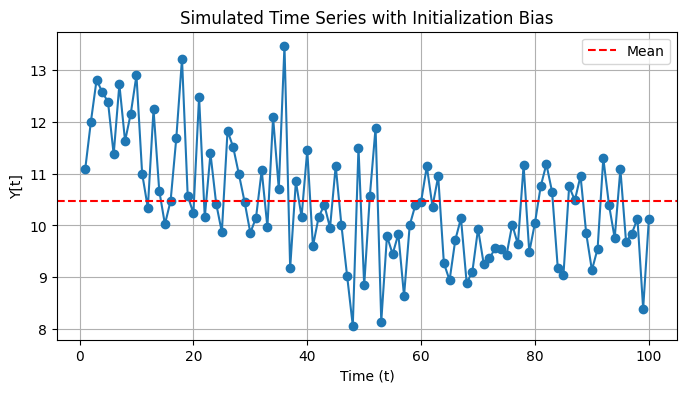

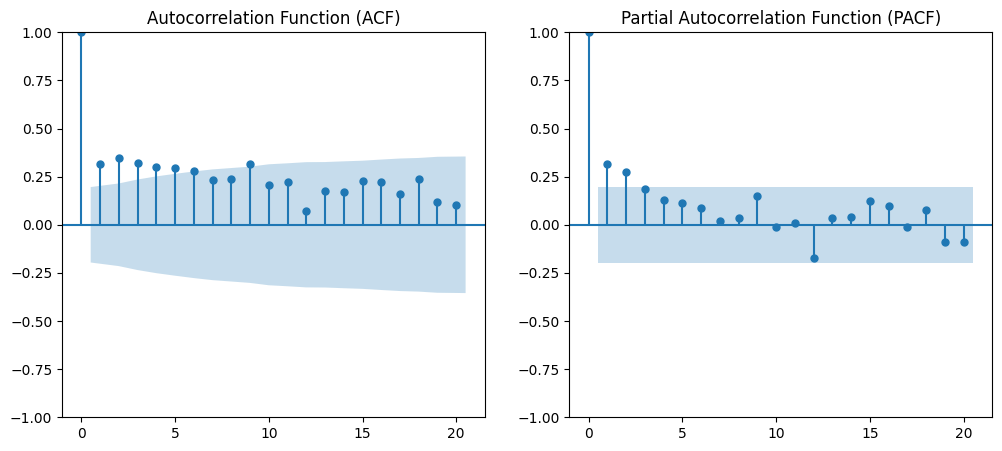

      lb_stat  lb_pvalue
5    4.266485   0.511721
10   9.301932   0.503709
15  13.217304   0.585518
Initialization Bias Test Results:
test_statistic: 5.8987503707186555
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
stationary_mean: 9.946699278665633
stationary_std_dev: 0.8058288911343386
effective_sample_size: 50
t_critical: 1.6759050251630974


In [11]:
# Simulation parameters
num_observations = 100  # Number of observations in the time series
true_mean = 10          # True stationary mean of the process
bias_amplitude = 2      # Amplitude of the initial bias
decay_parameter = 0.95  # Decay parameter for the bias
error_std_dev = 1.0     # Standard deviation of the random errors
np.random.seed(328422)  # Set seed for reproducibility

# Simulate the time series with initialization bias
# The model is: Y[t] = true_mean + bias_amplitude * decay_parameter^t + error[t]
# where error[t] ~ N(0, error_std_dev^2)

errors = np.random.normal(0, error_std_dev, num_observations) # Generate the random errors
time_series_data = [true_mean + bias_amplitude * (decay_parameter ** t) + errors[t] for t in range(num_observations)]

# Visualize the simulated time series
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, num_observations + 1), time_series_data, marker='o', linestyle='-')
mean_value = np.mean(time_series_data)
plt.axhline(y=mean_value, color='red', linestyle='--', label='Mean')
plt.xlabel('Time (t)')
plt.ylabel('Y[t]')
plt.title('Simulated Time Series with Initialization Bias')
plt.legend() 
plt.grid(True)
plt.show()

# Analyze autocorrelation (ACF and PACF plots) to determine AR order (p)
plot_acf_pacf(time_series_data, lags=20)  # Plot ACF and PACF
plt.show()

# Determine appropriate AR order (p) and perform bias test
initial_ar_order = 2 

# Check if the chosen AR order is appropriate 
if correct_p(time_series_data, initial_ar_order):
    bias_test_result = test_initialization_bias(time_series_data, initial_ar_order, alpha=0.05, bias_type='pos')
    print("Initialization Bias Test Results:")
    for key, value in bias_test_result.items():
        print(f"{key}: {value}")
else:
    print(f"The chosen AR order (p={initial_ar_order}) is not appropriate. Please adjust and try again.")

### Example 2 M/M/1 queue
<p style="text-align: justify;">
This simulation investigates an M/M/1 queue, where customers arrive according to a Poisson process and service times follow an exponential distribution. The traffic intensity is set to 0.9, indicating a system with high utilisation. The simulation's output is the waiting time for each customer. To introduce an initialisation bias, 'with bias' simulations commence with the system empty, an initial condition that is not representative of the steady state. Conversely, 'without bias' simulations initiate by sampling from a known distribution that represents the steady state of the system. The simulation includes multiple replications to reduce variability and obtain more robust results.
</p>

In [12]:
np.random.seed(328422)  # Set seed for reproducibility

def simulate_mm1_queue(run_type, num_service_completions, arrival_rate=0.9, service_rate=1.0):
    """
    Simulates an M/M/1 queue for a specified number of service completions

    Args:
        run_type (str): 'biased' for runs initialized with an empty system
                        'unbiased' for runs initialized from the stationary distribution
        num_service_completions (int): The number of service completions to simulate
        arrival_rate (float): The arrival rate (lambda). Defaults to 0.9
        service_rate (float): The service rate (mu). Defaults to 1.0

    Returns:
        numpy.ndarray: An array of waiting times for each customer
    """

    waiting_times = np.zeros(num_service_completions)

    # Initialize the system state (number of customers) based on the run type
    if run_type == 'biased':
        # Biased run: System starts empty
        num_initial_customers = 0 
    elif run_type == 'unbiased':
        # Unbiased run: System starts from the stationary distribution
        traffic_intensity = arrival_rate / service_rate  # Calculate traffic intensity (rho)
        num_initial_customers = np.random.geometric(1 - traffic_intensity) - 1  # Geometric distribution for queue length in M/M/1
    else:
        raise ValueError("run_type must be 'biased' or 'unbiased'")  

    # Initialize the total work (remaining service time) in the system
    if num_initial_customers > 0:
        remaining_work = np.sum(np.random.exponential(1/service_rate, size=num_initial_customers))
    else:
        remaining_work = 0.0

    # Simulate waiting times using Lindley's equation
    for i in range(num_service_completions):
        interarrival_time = np.random.exponential(1/arrival_rate)  # Time until next arrival
        service_time = np.random.exponential(1/service_rate)      # Service time for the current customer
        remaining_work = max(remaining_work + service_time - interarrival_time, 0)  # Lindley's equation
        waiting_times[i] = remaining_work # Waiting time is the remaining work when the customer arrives

    return waiting_times

##### Results of the simulations with and without bias
<p style="text-align: justify;">
The following comparison of two different simulations of average waiting times is presented in the plot <strong>Average Waiting Time Series for BIASED and UNBIASED Runs</strong>: one with an initialization bias (blue) and one that is initially stationary (orange). The main time series plot demonstrates that the biased simulation exhibits significant fluctuations before stabilising, while the unbiased simulation appears to maintain a more consistent behaviour throughout. The mean values for both runs are displayed with dashed lines, showing that the biased simulation starts with a strong deviation before eventually converging.
</p>

<p style="text-align: justify;">
The ACF and the PACF functions for the biased simulation demonstrate a high degree of persistence, with the autocorrelations maintaining a significant positive value over a considerable number of lags. This finding indicates that the initial values in the biased simulation significantly influence future observations, a characteristic of initialization bias. The test statistic corroborates this observation, as <strong>the null hypothesis of no initialization bias is rejected</strong>, thereby indicating substantial evidence of bias. The estimated stationary mean and standard deviation are indicative of this instability, thereby reinforcing the conclusion that the system required time to reach a steady state.
</p>

<p style="text-align: justify;">
In contrast, the unbiased simulation's ACF and PACF plots demonstrate a significantly faster decay in autocorrelation, suggesting that the system behaves more akin to a stationary process. <strong>The hypothesis test does not reject the null hypothesis</strong>, indicating that there is a lack of evidence to substantiate the claim of initialization bias. The estimated stationary mean and standard deviation further corroborate this stability.
</p>

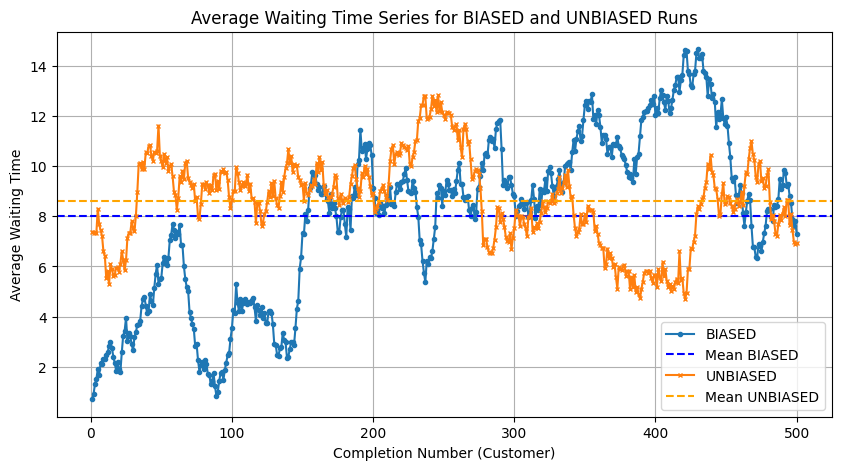

Simulation BLUE - With bias


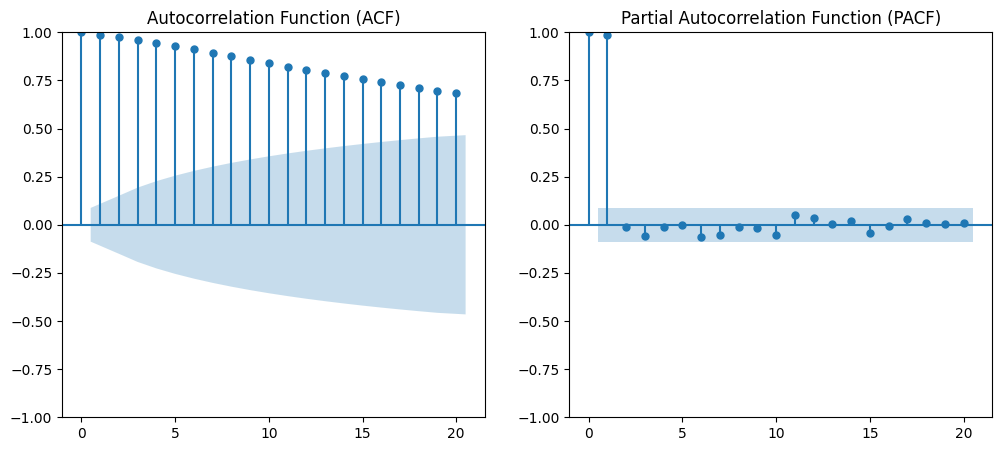

      lb_stat  lb_pvalue
5    2.942465   0.708856
10  14.923880   0.134862
15  18.779019   0.223923
Results BIASED:
test_statistic: 18.35484320244727
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
stationary_mean: 9.84535920755938
stationary_std_dev: 1.9429869885029172
effective_sample_size: 147
t_critical: 1.6552854366066903

Simulation ORANGE - Initially stationary


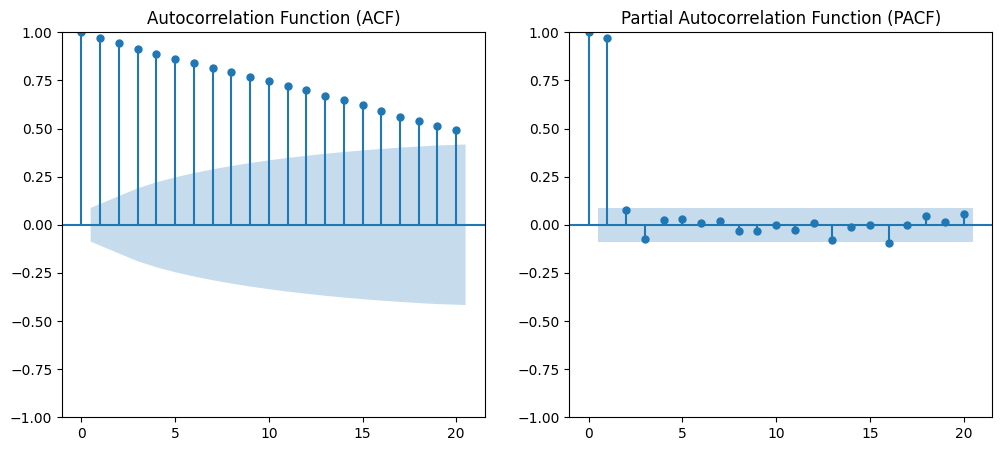

      lb_stat  lb_pvalue
5    3.421879   0.635240
10   4.030756   0.945949
15  10.166787   0.809119
Results UNBIASED:
test_statistic: -4.446269138741883
decision: The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
stationary_mean: 8.464906481464777
stationary_std_dev: 1.9548649878399762
effective_sample_size: 170
t_critical: 1.6538663174513006


In [13]:
# Simulation parameters
num_replications = 10
num_completions = 500

# Simulate replications for the BIASED run (initially empty system)
biased_runs = []
for rep in range(num_replications):
    waiting_times = simulate_mm1_queue('biased', num_completions, arrival_rate=0.9, service_rate=1.0)
    biased_runs.append(waiting_times)

biased_runs = np.array(biased_runs)
avg_biased_waiting_times = np.mean(biased_runs, axis=0)  # Average waiting times across replications

# Simulate replications for the UNBIASED run (from stationary distribution)
unbiased_runs = []
for rep in range(num_replications):
    waiting_times = simulate_mm1_queue('unbiased', num_completions, arrival_rate=0.9, service_rate=1.0) 
    unbiased_runs.append(waiting_times)

unbiased_runs = np.array(unbiased_runs)
avg_unbiased_waiting_times = np.mean(unbiased_runs, axis=0)  # Average waiting times

# Visualize the average waiting time series
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, num_completions + 1), avg_biased_waiting_times, label="BIASED", marker='o', markersize=3, linestyle='-')
plt.axhline(y=np.mean(avg_biased_waiting_times), color='blue', linestyle='--', label="Mean BIASED") 
plt.plot(np.arange(1, num_completions + 1), avg_unbiased_waiting_times, label="UNBIASED", marker='x', markersize=3, linestyle='-')
plt.axhline(y=np.mean(avg_unbiased_waiting_times), color='orange', linestyle='--', label="Mean UNBIASED")
plt.xlabel("Completion Number (Customer)")
plt.ylabel("Average Waiting Time")
plt.title("Average Waiting Time Series for BIASED and UNBIASED Runs")
plt.legend()
plt.grid(True)
plt.show()

# --- Analysis of BIASED runs ---
print("Simulation BLUE - With bias")
plot_acf_pacf(avg_biased_waiting_times, lags=20)  # Plot ACF and PACF for biased runs
p_1 = 3  
correct_1 = correct_p(avg_biased_waiting_times, p_1, lags=[5, 10, 15])
if not correct_1:
    print(f"p={p_1} is NOT correct for biased runs")

result_biased = test_initialization_bias(avg_biased_waiting_times, p_1, alpha=0.05, bias_type='neg')  # Test for negative bias
print("Results BIASED:")
for k, v in result_biased.items():
    print(f"{k}: {v}")

# --- Analysis of UNBIASED runs ---
print("\nSimulation ORANGE - Initially stationary")
plot_acf_pacf(avg_unbiased_waiting_times, lags=20)  # Plot ACF and PACF for unbiased runs
p_2 = 2  
correct_2 = correct_p(avg_unbiased_waiting_times, p_2, lags=[5, 10, 15])
if not correct_2:
    print(f"p={p_2} is NOT correct for biased runs")

result_unbiased = test_initialization_bias(avg_unbiased_waiting_times, p_2, alpha=0.05) 
print("Results UNBIASED:")
for k, v in result_unbiased.items():
    print(f"{k}: {v}")

## Tests for Transient Means in Simulated Times Series


<p style="text-align: justify;">
Simulation studies often require an accurate estimation of steady-state performance, yet the presence of transient means in a simulated time series can lead to biased results. This paper introduces a family of statistical tests designed to detect transient means in simulation output. The tests are based on comparing variance estimators from different segments of a simulation run, leveraging batch means and standardized time series methods. By analyzing differences between these variance estimates, the tests serve as a diagnostic tool to identify initialization effects that might distort performance metrics.
</p>

<h4 style="text-align: justify;">Overview of the Transient Mean Detection Method</h4>

<p style="text-align: justify;">
This paper presents a statistical approach to detecting transient means in simulation output, which can lead to biased estimates of steady-state parameters. The central idea is to divide the output sequence into two contiguous, non-overlapping portions and compute variance estimates separately for each. Under the null hypothesis that the process is stationary, the variance estimates should be similar; significant differences suggest the presence of transient means. The method assumes that the simulation output follows a stochastic process with a transient mean function, typically decaying toward a steady state, and that the output data exhibit serial correlation.
</p>

<p style="text-align: justify;">
The detection process involves estimating the variance using different statistical techniques: batch means, area-based estimators derived from standardized time series, and maximum deviation estimators. The variance estimators are compared using an F-test, where the null hypothesis states that the two portions of the output have equal variance. If the test statistic exceeds a critical value from the F-distribution, transient means are detected, indicating potential initialization bias.
</p>

<p style="text-align: justify;">
The test statistic is computed as:
</p>

<p style="text-align: justify; text-align: center;">
$$ F = \frac{V_{k,b'}}{V_{k,b-b'}}, $$
</p>

<p style="text-align: justify;">
where \( V_{k,b'} \) and \( V_{k,b-b'} \) represent variance estimates computed from the first \( b' \) and last \( b - b' \) batches of the simulation output, respectively. The choice of variance estimator \( k \) determines whether the test is based on batch means, area under the standardized time series, or maximum deviation within batches.
</p>

<h4 style="text-align: justify;">Algorithm for Detecting Transient Means</h4>

<ol style="text-align: justify;">
  <li>
    <strong>Divide the Simulation Output.</strong>  
    Partition the time series into two contiguous, non-overlapping segments, selecting the number of batches \( b' \) and \( b - b' \).
  </li>

  <li>
    <strong>Estimate the Variance.</strong>  
    Compute variance estimates \( V_{k,b'} \) and \( V_{k,b-b'} \) using one of the following methods:
    <ul>
      <li><em>Batch Means:</em> Compute variance from batch means across segments.</li>
      <li><em>Standardized Time Series (Area Method):</em> Use the integral of the standardized series over time.</li>
      <li><em>Maximum Deviation:</em> Compare the maximum deviations observed in the segments.</li>
    </ul>
  </li>

  <li>
    <strong>Compute the F-Statistic.</strong>  
    Compute
    <br>
    $$ F = \frac{V_{k,b'}}{V_{k,b-b'}}. $$
  </li>

  <li>
    <strong>Determine the Significance Level.</strong>  
    Compare the computed \( F \) value with the critical value \( f_{d_1, d_2, \alpha} \) from the F-distribution with degrees of freedom \( d_1 \) and \( d_2 \) corresponding to the number of batches in each segment.
  </li>

  <li>
    <strong>Decision Rule.</strong>  
    If \( F > f_{d_1, d_2, \alpha} \), reject the null hypothesis and conclude that transient means are present in the simulation output.
  </li>
</ol>

#### Auxiliary functions
<p style="text-align: justify;">
These functions are designed to estimate the variance of a time series using different methods, primarily focusing on techniques that leverage the concept of batch means. The core idea is to divide the time series into smaller, non-overlapping batches and then use the variation between these batches to estimate the overall variance of the process.  These functions are typically used as part of a larger analysis, such as the transient mean test, to assess properties of a time series, particularly in the context of simulation output analysis.
</p>
<p style="text-align: justify;">
<code>partition_into_batches</code> is the utility function that handles the initial step: dividing the input time series data into batches of a specified size.  It ensures the number of observations is divisible by the batch size and raises a `ValueError` if it isn't. It returns both the set of batches (as a NumPy array) and their respective means (also a NumPy array). This function is crucial as it prepares the data for all subsequent variance estimation methods.
</p>
<p style="text-align: justify;">
The remaining functions each implement a different variance estimation method:

<ul>
    <li>
        <code>batch_means_variance_estimator</code>: This is the most straightforward approach. It calculates the variance of the <em>batch means</em> and scales it up by the batch size to estimate the variance of the original time series.  It uses `ddof=1` in `np.var` for an unbiased estimate of the variance. This method is computationally efficient but can be sensitive to the choice of batch size and may not be as accurate as other methods, especially if there's autocorrelation within the batches.
    </li>
    <li>
        <code>area_variance_estimator</code>: This method is based on the "area" between the cumulative means of each batch and the overall mean of that batch. It calculates standardized differences between cumulative means and batch mean, weights them linearly based on time points within the batch, and then calculates a weighted sum for each batch. The variance is then computed from these weighted sums. It's a more sophisticated technique that can be more accurate than the basic batch means estimator, especially when dealing with time series that exhibit trends or non-stationarity. The `scale_estimate` argument provides an initial estimate of the standard deviation, often derived from the batch means variance estimator.
    </li>
    <li>
        <code>maximum_variance_estimator</code>: This method identifies the position of the maximum absolute standardized deviation of the cumulative means within each batch. The variance is calculated on these positions (normalized by batch size). Similar to the area method, it utilizes an initial `scale_estimate`. This approach focuses on extreme deviations within each batch.
    </li>
    <li>
        <code>combined_bm_area_estimator</code> and <code>combined_bm_maximum_estimator</code>: These functions combine the basic batch means variance estimate with the area and maximum variance estimates, respectively, by averaging them. Combining estimators can often lead to more robust and accurate results, as they leverage different aspects of the data.  Averaging gives equal weight to both methods.
    </li>
</ul>
</p>
<p style="text-align: justify;">
Finally, <code>compute_variance_estimator</code> acts as a central point to select and execute the desired variance estimation method. Based on the `method` parameter (an integer), it calls the appropriate function to compute the variance.  It handles the initial calculation of `scale_estimate` which is needed by several of the variance estimators. This structure allows for easy addition of other variance estimation techniques in the future.
</p>

In [14]:
def partition_into_batches(time_series_data, batch_size):
    """
    Partitions time series data into batches of a specified size

    Args:
        time_series_data (numpy.ndarray): The time series data
        batch_size (int): The desired size of each batch

    Returns:
        tuple: A tuple containing the batches and the means of each batch

    Raises:
        ValueError: If the number of observations is not a multiple of the batch size
    """
    num_observations = len(time_series_data)
    if num_observations % batch_size != 0:
        raise ValueError("Number of observations must be a multiple of batch size.")
    num_batches = num_observations // batch_size
    batches = np.reshape(time_series_data, (num_batches, batch_size))  # Reshape data into batches
    batch_means = np.mean(batches, axis=1)  # Calculate the mean of each batch
    return batches, batch_means


def batch_means_variance_estimator(batch_means, batch_size):
    """
    Estimates the variance of the underlying process using the batch means

    Args:
        batch_means (numpy.ndarray): The means of each batch
        batch_size (int): The size of each batch

    Returns:
        float: The estimated variance
    """
    num_batches = len(batch_means)
    sample_variance = np.var(batch_means, ddof=1)  # Calculate the sample variance of the batch means (ddof=1 for unbiased estimator)
    variance_estimate = batch_size * sample_variance  # Scale the sample variance to estimate the process variance
    return variance_estimate


def area_variance_estimator(batches, batch_size, scale_estimate):
    """
    Estimates the variance of the underlying process using the area method

    Args:
        batches (numpy.ndarray): The batches of time series data
        batch_size (int): The size of each batch
        scale_estimate (float): An initial estimate of the scale 

    Returns:
        float: The estimated variance
    """
    num_batches = batches.shape[0]
    area_values = np.zeros(num_batches)
    sqrt_12 = np.sqrt(12)  # Normalization factor used in the weight calculation

    for i in range(num_batches):
        batch_data = batches[i]
        batch_mean = np.mean(batch_data)
        time_points = np.arange(1, batch_size + 1, dtype=float) / batch_size # Create normalized time points within the batch (from 1/batch_size to 1)
        cumulative_means = np.cumsum(batch_data) / np.arange(1, batch_size + 1, dtype=float) # Calculate cumulative means within the batch
        standardized_diffs = np.sqrt(batch_size) * (cumulative_means - batch_mean) / scale_estimate # Standardize the difference between cumulative and batch mean, scaled by sqrt(batch_size)
        weights = sqrt_12 * (time_points - 0.5) # Calculate the weights based on the normalized time points
        area_values[i] = np.sum(weights * standardized_diffs) / batch_size # Calculate the weighted sum of standardized differences for each batch. This is the "area" value

    variance_estimate = np.var(area_values, ddof=1)  # Calculate the variance of the area values (ddof=1 for unbiased estimator)
    return variance_estimate

def combined_bm_area_estimator(batch_means, batches, batch_size, scale_estimate):
    """
    Combines the Batch Means and Area variance estimators

    Args:
        batch_means (numpy.ndarray): The means of each batch
        batches (numpy.ndarray): The batches of time series data
        batch_size (int): The size of each batch
        scale_estimate (float): An initial estimate of the scale

    Returns:
        float: The combined variance estimate
    """
    bm_variance = batch_means_variance_estimator(batch_means, batch_size)  # Calculate variance using Batch Means
    area_variance = area_variance_estimator(batches, batch_size, scale_estimate)  # Calculate variance using Area method
    return 0.5 * (bm_variance + area_variance)  # Average the two variance estimates


def maximum_variance_estimator(batches, batch_size, scale_estimate):
    """
    Estimates the variance using the maximum absolute standardized cumulative mean deviation

    Args:
        batches (numpy.ndarray): The batches of time series data
        batch_size (int): The size of each batch
        scale_estimate (float): An initial estimate of the scale

    Returns:
        float: The estimated variance
    """
    num_batches = batches.shape[0]
    max_values = np.zeros(num_batches)

    for i in range(num_batches):
        batch_data = batches[i]
        batch_mean = np.mean(batch_data)
        cumulative_means = np.cumsum(batch_data) / np.arange(1, batch_size + 1, dtype=float)  # Calculate cumulative means
        standardized_values = np.sqrt(batch_size) * (cumulative_means - batch_mean) / scale_estimate  # Standardize the cumulative means
        max_values[i] = np.argmax(np.abs(standardized_values)) / batch_size  # Find the position of the maximum absolute standardized value, normalized by batch size

    variance_estimate = np.var(max_values, ddof=1)  # Calculate the variance of the positions
    return variance_estimate


def combined_bm_maximum_estimator(batch_means, batches, batch_size, scale_estimate):
    """
    Combines the Batch Means and Maximum variance estimators

    Args:
        batch_means (numpy.ndarray): The means of each batch
        batches (numpy.ndarray): The batches of time series data
        batch_size (int): The size of each batch
        scale_estimate (float): An initial estimate of the scale

    Returns:
        float: The combined variance estimate
    """
    bm_variance = batch_means_variance_estimator(batch_means, batch_size)  # Calculate variance using Batch Means
    max_variance = maximum_variance_estimator(batches, batch_size, scale_estimate)  # Calculate variance using Maximum method
    return 0.5 * (bm_variance + max_variance)  # Average the two variance estimates


def compute_variance_estimator(time_series_data, batch_size, method):
    """
    Computes the variance estimate using the specified method

    Args:
        time_series_data (numpy.ndarray): The time series data
        batch_size (int): The size of each batch
        method (int): The method to use:
            0: Batch Means (BM)
            1: Area
            2: Combined BM and Area
            3: Maximum
            4: Combined BM and Maximum

    Returns:
        float: The variance estimate

    Raises:
        ValueError: If an invalid method is specified
    """
    batches, batch_means = partition_into_batches(time_series_data, batch_size)  # Partition the data into batches
    if method == 0:
        variance_estimate = batch_means_variance_estimator(batch_means, batch_size)  # Use Batch Means method
    elif method in [1, 2, 3, 4]:
        initial_variance_estimate = batch_means_variance_estimator(batch_means, batch_size) 
        scale_estimate = np.sqrt(initial_variance_estimate)  # Estimate the scale (standard deviation)
        if method == 1:
            variance_estimate = area_variance_estimator(batches, batch_size, scale_estimate)  # Use Area method
        elif method == 2:
            variance_estimate = combined_bm_area_estimator(batch_means, batches, batch_size, scale_estimate)  # Combine BM and Area
        elif method == 3:
            variance_estimate = maximum_variance_estimator(batches, batch_size, scale_estimate)  # Use Maximum method
        elif method == 4:
            variance_estimate = combined_bm_maximum_estimator(batch_means, batches, batch_size, scale_estimate)  # Combine BM and Maximum
    else:
        raise ValueError("Invalid method. Choose 0 (BM), 1 (Area), 2 (BM+Area), 3 (Maximum), or 4 (BM+Maximum).")
    return variance_estimate

#### Main functions
<p style="text-align: justify;">
These functions, <code>compute_test_statistic</code> and <code>transient_mean_test</code>, are designed to perform a statistical test for the presence of initialization bias in time series data.
</p>

<p style="text-align: justify;">
<code>compute_test_statistic</code> is the core function of this process. It takes the time series data, divides it into non-overlapping batches of a specified size using `partition_into_batches`, and then focuses on two portions: an initial set of batches (representing the potentially biased start) and the remaining batches (assumed to be closer to the steady state). For each of these portions, it calculates a variance estimate using a chosen method (specified by the `method` parameter and relying on other functions like `compute_variance_estimator`). The core idea is to compare the variability in the initial part of the data to the variability in the latter part. The ratio of these variance estimates forms the test statistic, which follows an F-distribution under the null hypothesis (no initialization bias). This test statistic is then used to determine if there's a statistically significant difference, suggesting initialization bias. The function also calculates the necessary degrees of freedom for the F-test:  `degrees_of_freedom1` (for the numerator, the initial portion) and `degrees_of_freedom2` (for the denominator, the final portion).
</p>

<p style="text-align: justify;">
<code>transient_mean_test</code> takes the baton from <code>compute_test_statistic</code>. It performs the actual statistical test using the calculated test statistic and degrees of freedom. It compares the test statistic to a critical value from the F-distribution (determined by the chosen significance level, `alpha`). This critical value is obtained using the percent point function (`f.ppf`) of the F-distribution. If the test statistic exceeds this critical value, the null hypothesis (that there is no initialization bias) is rejected, and the function concludes that there *is* evidence of bias. Otherwise, it fails to reject the null hypothesis. The function returns a dictionary containing all the relevant information: the test statistic, degrees of freedom, the critical F-value, the decision about rejecting the null hypothesis (a boolean), and a textual description of the decision. Essentially, these functions provide a structured way to quantify and statistically assess initialization bias within a time series.
</p>

In [15]:
def compute_test_statistic(time_series, batch_size, num_initial_batches, method):
    """
    Calculates the test statistic for the transient mean test
    Divides the time series into batches, calculates variance estimates for the initial and final portions, and computes their ratio (the test statistic)

    Args:
        time_series (numpy.ndarray): The time series data
        batch_size (int): The size of each batch
        num_initial_batches (int): The number of initial batches to consider
        method (int): The method used to compute variance estimates

    Returns:
        tuple: A tuple containing the test statistic, degrees of freedom 1, and degrees of freedom 2
    """
    num_observations = len(time_series)
    if num_observations % batch_size != 0:
        raise ValueError("Number of observations must be a multiple of batch size.")

    num_batches = num_observations // batch_size
    batches, _ = partition_into_batches(time_series, batch_size)  # Partition time series into batches

    # Calculate variance estimate for the initial portion
    initial_data = np.reshape(batches[:num_initial_batches, :], (-1))  # Select and reshape data from initial batches
    variance_initial = compute_variance_estimator(initial_data, batch_size, method)  # Estimate variance of initial data

    # Calculate variance estimate for the final portion
    final_data = np.reshape(batches[num_initial_batches:, :], (-1))  # Select and reshape data from remaining batches
    variance_final = compute_variance_estimator(final_data, batch_size, method)  # Estimate variance of final data

    test_statistic = variance_initial / variance_final  # Calculate the test statistic (ratio of variances)
    degrees_of_freedom1 = num_initial_batches - 1  # Degrees of freedom for the numerator (initial portion)
    degrees_of_freedom2 = (num_batches - num_initial_batches) - 1  # Degrees of freedom for the denominator (final portion)
    return test_statistic, degrees_of_freedom1, degrees_of_freedom2


def transient_mean_test(time_series, batch_size, num_initial_batches, alpha, method):
    """
    Performs the transient mean test
    Calculates the test statistic, determines the critical F-value, and decides whether to reject the null hypothesis (i.e., whether there is bias)

    Args:
        time_series (numpy.ndarray): The time series data
        batch_size (int): The size of each batch
        num_initial_batches (int): The number of initial batches to consider
        alpha (float): The significance level
        method (int): The method used to compute variance estimates

    Returns:
        dict: A dictionary containing the test statistic, degrees of freedom, critical F-value, rejection decision, and a descriptive message
    """
    test_statistic, degrees_of_freedom1, degrees_of_freedom2 = compute_test_statistic(time_series, batch_size, num_initial_batches, method)  # Compute test statistic and degrees of freedom
    f_critical = f.ppf(1 - alpha, degrees_of_freedom1, degrees_of_freedom2)  # Calculate the critical F-value for the given alpha and degrees of freedom
    reject_null_hypothesis = test_statistic > f_critical  # Determine if the null hypothesis should be rejected

    if reject_null_hypothesis:
        decision = "The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias" 
    else:
        decision = "The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination"  

    return {
        "test_statistic": test_statistic,
        "degrees_of_freedom1": degrees_of_freedom1,
        "degrees_of_freedom2": degrees_of_freedom2,
        "f_critical": f_critical,
        "reject_null_hypothesis": reject_null_hypothesis,
        "decision": decision
    }

<p style="text-align: justify;">
The following two examples (simulations) will now be applied to all implemented methods. In accordance with predictions, the outcomes of the tests will vary, with some methods demonstrating success and others failure. This will illustrate how differing simulation structures can differentially stress the test, thereby revealing both its strengths and limitations.
</p>

#### Example 1 - An Inventory System 
<p style="text-align: justify;">
The objective of this study is to evaluate the performance of different variance estimation methods in detecting initialization bias.  This bias arises from the transient behavior of a time series, where the initial values are not representative of the steady-state behavior. The code simulates a time series (X) based on a transient mean function. For observations 1 to 1000, the theoretical mean (E[X_p]) decreases linearly, and beyond 1000, it remains constant. Random normal noise is added to create the simulated series. The simulation is repeated multiple times to account for randomness and to assess the consistency of the variance estimation methods.
</p>

<p style="text-align: justify;">
These functions work together to simulate and analyze a time series with a specific form of initialization bias. The goal is to understand how this bias affects the data and to test statistical methods for detecting it.
</p>
<p style="text-align: justify;">
<code>simulate_example1_run</code> generates a single instance of the time series. The core of the simulation lies in how the mean of the series is constructed. For the first 1000 observations, the mean decreases linearly from `mu` to 0. After observation 1000, the mean becomes constant at `mu`. This creates a distinct "transient" period at the beginning of the series. Random normal noise (with a standard deviation of 1.0) is then added to this mean function to create the actual simulated data. The random seed is set based on the `method` parameter, allowing for different random number streams for different variance estimation methods.
</p>
<p style="text-align: justify;">
<code>plot_simulation</code> (a common function used in multiple examples) takes the simulated data and its corresponding theoretical mean values and creates a plot. This visualization helps in seeing the effect of the transient mean – how the simulated data initially deviates from the long-term mean before settling down. The theoretical mean is plotted as a red line for comparison. The plot title also indicates the example number and the variance estimation method being used.
</p>
<p style="text-align: justify;">
<code>run_simulations_example1</code> orchestrates the entire simulation and analysis process for Example 1. It runs the simulation multiple times (`num_runs`), each time generating a new instance of the time series. For each run, it calls the plotting function (`plot_simulation`) to visualize the data and then calls `transient_mean_test` (defined elsewhere) to perform a statistical test for initialization bias. The results of this test, including the test statistic, degrees of freedom, critical F-value, the decision regarding the null hypothesis (reject or not reject), and a descriptive message, are printed for each run. This function allows for running multiple simulations with different variance estimation methods (BM, Area, BM+Area, Maximum, BM+Maximum) to compare their effectiveness in detecting the initialization bias.
</p>

##### Results of the simulations
<p style="text-align: justify;"> The results illustrate the behavior of different initialization bias correction methods applied to a simulated time series. The five methods tested—BM, Area, BM+Area, Maximum, and BM+Maximum—show that the statistical test consistently identifies the bias in the initial transient phase. </p> <p style="text-align: justify;"><strong>Method BM (Batch Means):</strong></p> <ul style="text-align: justify;"> <li>The simulated series starts with a clear transient, aligning only partially with the theoretical mean in the early observations.</li> <li>The statistical test rejects the null hypothesis, indicating significant evidence of initialization bias.</li> </ul> <p style="text-align: justify;"><strong>Method Area:</strong></p> <ul style="text-align: justify;"> <li>The theoretical mean and the simulated series may visually appear similar, the test does not rejects the null hypothesis.</li> </ul> <p style="text-align: justify;"><strong>Method BM+Area:</strong></p> <ul style="text-align: justify;"> <li>This hybrid approach combines Batch Means and Area smoothing.</li> <li>The test again rejects the null hypothesis, confirming that bias persists.</li> </ul> <p style="text-align: justify;"><strong>Method Maximum:</strong></p> <ul style="text-align: justify;"> <li>Visually, the simulated series appears close to the theoretical mean, yet the test does not rejects the null hypothesis.</li> </ul> <p style="text-align: justify;"><strong>Method BM+Maximum:</strong></p> <ul style="text-align: justify;"> <li>This combination similarly leads to a rejection of the null hypothesis, indicating that bias is present.</li> </ul> 


Executing simulations for Example 1 for method BM:


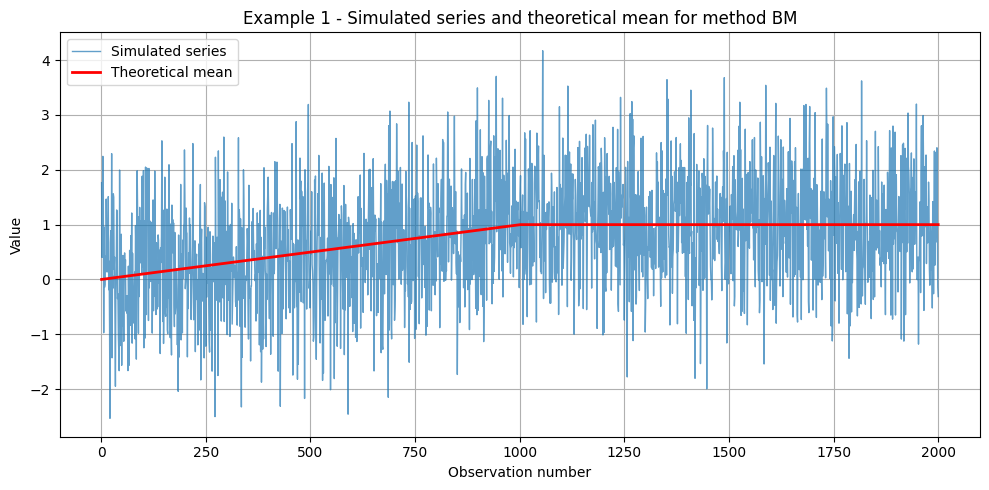

Test result for Example 1, run 1
test_statistic: 3.5541535904488764
degrees_of_freedom1: 7
degrees_of_freedom2: 11
f_critical: 3.0123303430431005
reject_null_hypothesis: True
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
------------------------------------------------------------------------------------------------------------------------------------------------------
Executing simulations for Example 1 for method Area:


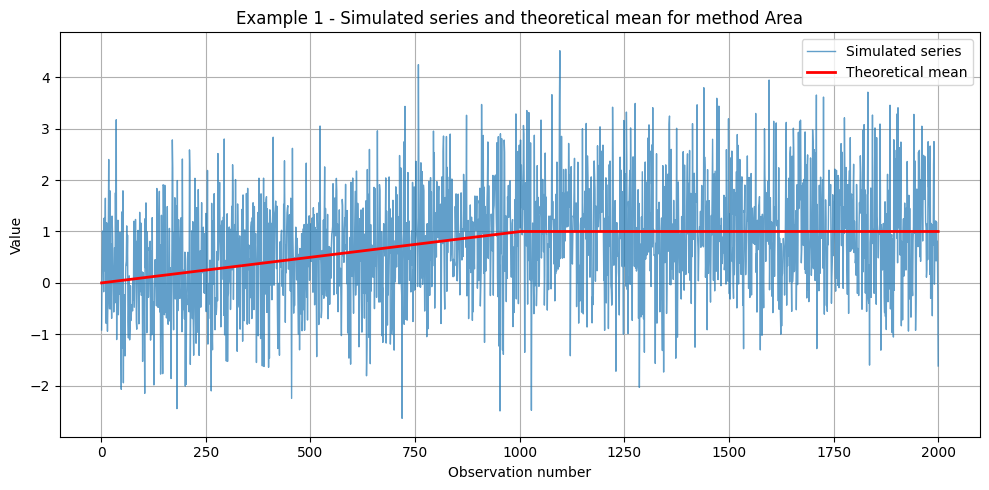

Test result for Example 1, run 1
test_statistic: 0.21864834651316548
degrees_of_freedom1: 7
degrees_of_freedom2: 11
f_critical: 3.0123303430431005
reject_null_hypothesis: False
decision: The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
------------------------------------------------------------------------------------------------------------------------------------------------------
Executing simulations for Example 1 for method BM+Area:


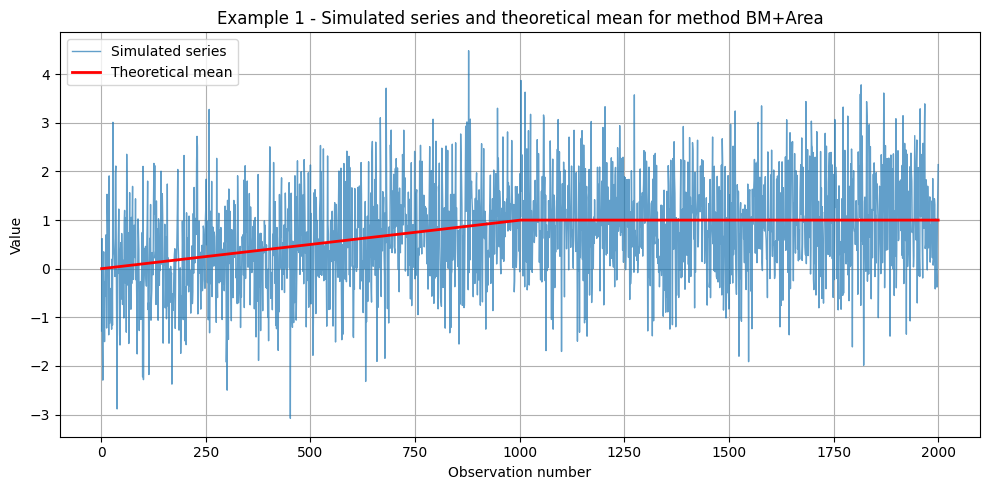

Test result for Example 1, run 1
test_statistic: 4.241834617751049
degrees_of_freedom1: 7
degrees_of_freedom2: 11
f_critical: 3.0123303430431005
reject_null_hypothesis: True
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
------------------------------------------------------------------------------------------------------------------------------------------------------
Executing simulations for Example 1 for method Maximum:


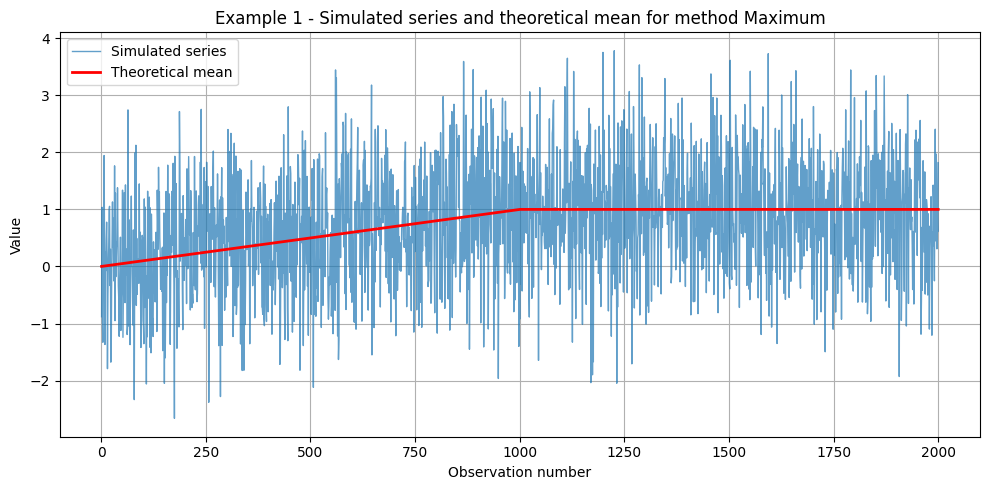

Test result for Example 1, run 1
test_statistic: 0.825543120473996
degrees_of_freedom1: 7
degrees_of_freedom2: 11
f_critical: 3.0123303430431005
reject_null_hypothesis: False
decision: The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
------------------------------------------------------------------------------------------------------------------------------------------------------
Executing simulations for Example 1 for method BM+Maximum:


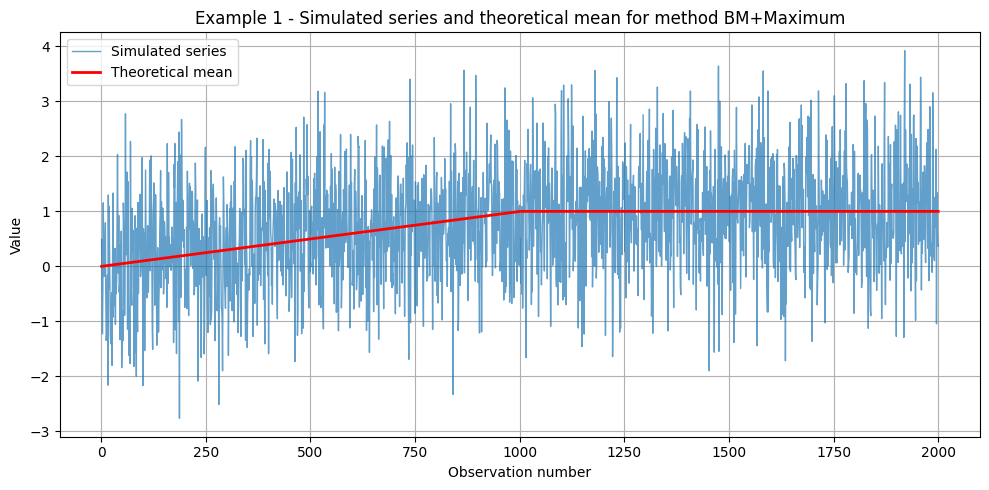

Test result for Example 1, run 1
test_statistic: 7.35163291223563
degrees_of_freedom1: 7
degrees_of_freedom2: 11
f_critical: 3.0123303430431005
reject_null_hypothesis: True
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
------------------------------------------------------------------------------------------------------------------------------------------------------


In [16]:
# =============================================================================
# COMMON FUNCTIONS
# =============================================================================

# Dictionary of method names (defined only once)
method_names = {0: 'BM', 1: 'Area', 2: 'BM+Area', 3: 'Maximum', 4: 'BM+Maximum'}

def plot_simulation(time_series_data, theoretical_mean, method, example_number):
    """
    Plots the simulated series and the theoretical mean
    
    Args:
        time_series_data (numpy.ndarray): The simulated series
        theoretical_mean (numpy.ndarray): The theoretical mean
        method (int): The method index
        example_number (int): Example number
    """
    observation_numbers = np.arange(1, len(time_series_data) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(observation_numbers, time_series_data, label="Simulated series", lw=1, alpha=0.7)
    plt.plot(observation_numbers, theoretical_mean, label="Theoretical mean", lw=2, color='red')
    plt.xlabel("Observation number")
    plt.ylabel("Value")
    plt.title(f"Example {example_number} - Simulated series and theoretical mean for method {method_names[method]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# =============================================================================
# FUNCTIONS FOR EXAMPLE 1 (Original Simulation)
# =============================================================================

def simulate_example1_run(num_observations=2000, mu=1.0, method=0):
    """
    Simulates a run for Example 1
    
    For observation numbers 1 to 1000: a_p = 1 - p/1000  =>  E[X_p] = mu*(1 - a_p)
    For observations > 1000: a_p = 0  =>  E[X_p] = mu
    Assumes variance 1
    
    Args:
        num_observations (int): Number of observations
        mu (float): Mean value
        method (int): Used to change the seed
        
    Returns:
        tuple: (time_series_data, theoretical_mean)
    """
    # Set random seed based on the method parameter
    np.random.seed(328422 * method)
    observation_numbers = np.arange(1, num_observations + 1)
    a_p = np.where(observation_numbers <= 1000, 1 - (observation_numbers / 1000), 0)
    theoretical_mean = mu * (1 - a_p)
    time_series_data = np.random.normal(loc=theoretical_mean, scale=1.0, size=num_observations)
    return time_series_data, theoretical_mean

def run_simulations_example1(num_runs=3, num_observations=2000, batch_size=100,
                             num_initial_batches=8, alpha=0.05, method=0):
    """
    Executes multiple simulations for Example 1
    
    For each run:
      - Prints the run number
      - Plots the simulated series and theoretical mean
      - Executes the transient mean test and prints the result
    
    Args:
        num_runs (int): Number of runs
        num_observations (int): Number of observations per run
        batch_size (int): Batch size
        num_initial_batches (int): Number of initial batches to consider
        alpha (float): Significance level
        method (int): Method used to estimate the variance
    """
    for run_number in range(1, num_runs + 1):
        time_series_data, theoretical_mean = simulate_example1_run(num_observations, mu=1.0, method=method)
        plot_simulation(time_series_data, theoretical_mean, method, example_number=1)
        test_result = transient_mean_test(time_series_data, batch_size, num_initial_batches, alpha, method)
        print("Test result for Example 1, run", run_number)
        for key, value in test_result.items():
            print(f"{key}: {value}")
        print("-" * 150)

# =============================================================================
# EXECUTION OF SIMULATION
# =============================================================================

# Execute simulations for Example 1
for method_index in range(0, 5):
    print(f"Executing simulations for Example 1 for method {method_names[method_index]}:")
    run_simulations_example1(num_runs=1, num_observations=2000, batch_size=100,
                             num_initial_batches=8, alpha=0.05, method=method_index)

#### Example 2 - M/M/1 Simulation
<p style="text-align: justify;">
This code simulates and analyzes data from an M/M/1 queuing system to investigate the impact of a time-varying component on observations and to test for initialization bias. Specifically, it replicates a process of interest (X) that combines customer waiting times (Z) with a term (u) that changes over time, mimicking a transient mean function. The waiting times Z are simulated from a stationary M/M/1 queue using <code>simulate_mm1</code>, discarding an initial "warmup" period to ensure stationarity. The time-varying component u is calculated as a function of the observation number, decreasing linearly for the first half of the observations and then remaining at zero. The <code>simulate_example2_run</code> function combines these elements to produce the final time series X. The <code>plot_simulation</code> function visualizes the simulated X along with its theoretical mean, which is influenced by the time-varying u. The <code>run_simulations_example2</code> function orchestrates multiple simulation runs, plotting the results and then applying the <code>transient_mean_test</code> to detect potential initialization bias. This setup allows for exploring how different variance estimation methods perform in the presence of this specific form of time-varying behavior. The code then runs these simulations for each of the specified methods.
</p>

##### Results of the simulations
<p style="text-align: justify;">
The results provide insights into the effectiveness of different initialization bias correction methods applied to an M/M/1 queue simulation. The five tested methods—BM, Area, BM+Area, Maximum, and BM+Maximum—yield varied outcomes in handling the initialization bias.
</p>

<p style="text-align: justify;">
As shown in the following graphs, this case study puts bias detection methods to the test. Indeed, the simulation shows a stability of the mean between the first 1000 and the next 1000 observations, suggesting the absence of significant variation. However, the combined BM+Area and BM+Maximum methods are able to correctly identify the presence of bias, unlike the individual methods which, instead, erroneously conclude that there is no bias.
</p>


Executing simulations for Example 2 for method BM:


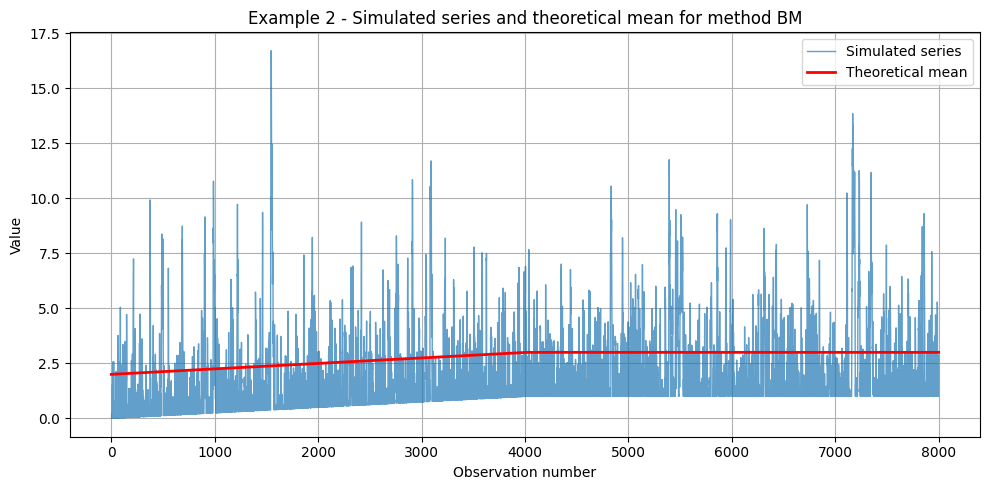

Test result for Example 2, run 1
test_statistic: 1.800903646402753
degrees_of_freedom1: 9
degrees_of_freedom2: 9
f_critical: 3.17889310445827
reject_null_hypothesis: False
decision: The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
------------------------------------------------------------------------------------------------------------------------------------------------------

Executing simulations for Example 2 for method Area:


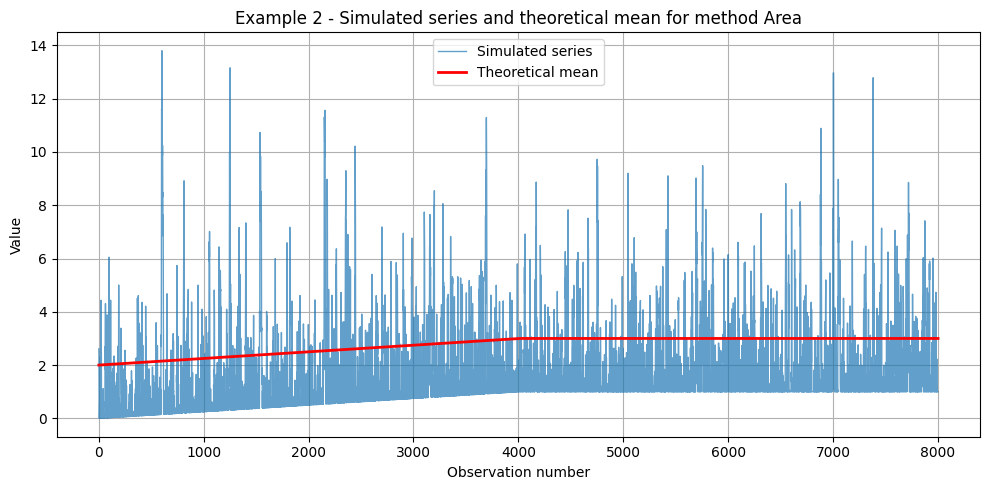

Test result for Example 2, run 1
test_statistic: 0.3151653427066806
degrees_of_freedom1: 9
degrees_of_freedom2: 9
f_critical: 3.17889310445827
reject_null_hypothesis: False
decision: The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
------------------------------------------------------------------------------------------------------------------------------------------------------

Executing simulations for Example 2 for method BM+Area:


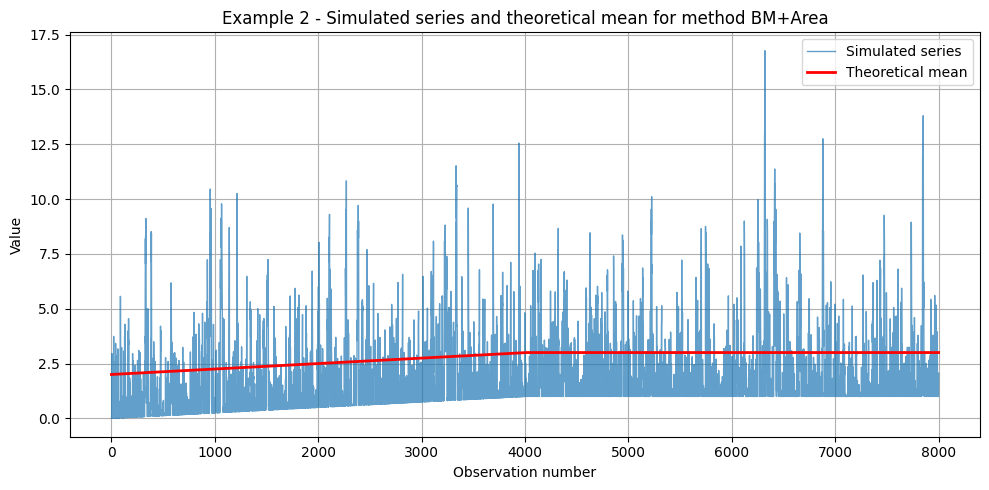

Test result for Example 2, run 1
test_statistic: 3.264038532808754
degrees_of_freedom1: 9
degrees_of_freedom2: 9
f_critical: 3.17889310445827
reject_null_hypothesis: True
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
------------------------------------------------------------------------------------------------------------------------------------------------------

Executing simulations for Example 2 for method Maximum:


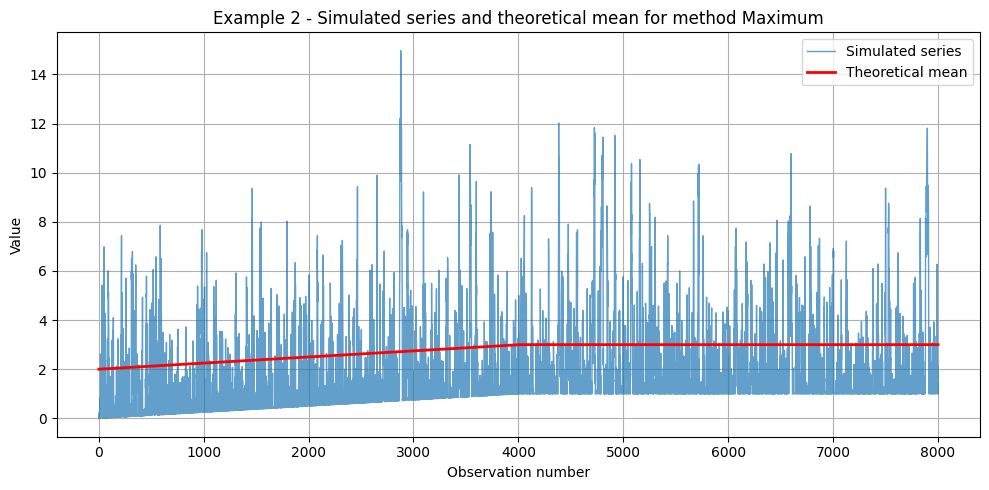

Test result for Example 2, run 1
test_statistic: 2.929527207850134
degrees_of_freedom1: 9
degrees_of_freedom2: 9
f_critical: 3.17889310445827
reject_null_hypothesis: False
decision: The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
------------------------------------------------------------------------------------------------------------------------------------------------------

Executing simulations for Example 2 for method BM+Maximum:


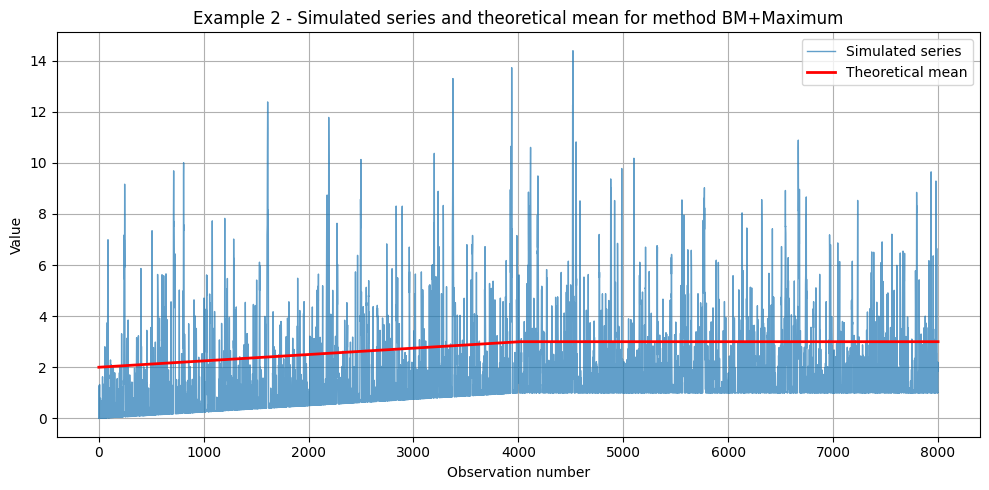

Test result for Example 2, run 1
test_statistic: 4.954375419634724
degrees_of_freedom1: 9
degrees_of_freedom2: 9
f_critical: 3.17889310445827
reject_null_hypothesis: True
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
------------------------------------------------------------------------------------------------------------------------------------------------------


In [17]:
# =============================================================================
# FUNCTIONS FOR EXAMPLE 2 (M/M/1 Simulation)
# =============================================================================

def simulate_mm1(n, arrival_rate=0.5, service_rate=1.0, warmup=1000, seed=328422):
    np.random.seed(seed)
    num_service_completions = n + warmup
    waiting_times = simulate_mm1_queue(run_type='biased', num_service_completions=num_service_completions, 
                                       arrival_rate=arrival_rate, service_rate=service_rate)
    return waiting_times[warmup:]

def simulate_example2_run(n=8000, arrival_rate=0.5, service_rate=1.0, warmup=1000, seed=328422, method=0):
    """
    Simulates a run for Example 2:
      - Simulates waiting times Z_p from an M/M/1 system in stationarity
      - Computes u_p = max(1 - p/4000, 0) for p = 1,..., n
      - Sets X_p = Z_p + 1 - u_p
    
    Returns:
        tuple: (simulated_series, theoretical_mean) where simulated_series is X and 
        theoretical_mean is computed as E[Z_p] + (1 - u), with E[Z_p] = 1 / (service_rate - arrival_rate)
    """
    Z = simulate_mm1(n, arrival_rate, service_rate, warmup, seed=328422 * method)
    p = np.arange(1, n + 1)
    u = np.maximum(1 - p / 4000, 0)
    X = Z + 1 - u
    E_Zp = 1 / (service_rate - arrival_rate)
    theoretical_mean = E_Zp + (1 - u)
    return X, theoretical_mean

def run_simulations_example2(num_runs=3, n=8000, arrival_rate=0.5, service_rate=1.0,
                             warmup=1000, batch_size=400, num_initial_batches=10, alpha=0.05, method=0):
    """
    Executes multiple simulations for Example 2
    
    For each run:
      - Prints the run number
      - Plots the simulated series and theoretical mean
      - Executes the transient mean test and prints the result
    
    Args:
        num_runs (int): Number of runs
        n (int): Total number of observations
        arrival_rate (float): Arrival rate
        service_rate (float): Service rate
        warmup (int): Warmup period to discard
        batch_size (int): Batch size
        num_initial_batches (int): Number of initial batches to consider
        alpha (float): Significance level
        method (int): Method used to estimate the variance
    """
    for run_number in range(1, num_runs + 1):
        simulated_series, theoretical_mean = simulate_example2_run(n, arrival_rate, service_rate, warmup, seed=328422, method=method)
        plot_simulation(simulated_series, theoretical_mean, method, example_number=2)
        test_result = transient_mean_test(simulated_series, batch_size, num_initial_batches, alpha, method)
        print("Test result for Example 2, run", run_number)
        for key, value in test_result.items():
            print(f"{key}: {value}")
        print("-" * 150)



# =============================================================================
# EXECUTION OF SIMULATION
# =============================================================================
# Execute simulations for Example 2
for method_index in range(0, 5):
    print(f"\nExecuting simulations for Example 2 for method {method_names[method_index]}:")
    run_simulations_example2(num_runs=1, n=8000, arrival_rate=0.5, service_rate=1.0,
                             warmup=1000, batch_size=400, num_initial_batches=10, alpha=0.05, method=method_index)

## Final Example 
<p style="text-align: justify;">
This model simulates the evolution of the <strong>average stock level</strong> in a real context, as it might occur in a company managing warehouses or in a logistics system. In particular, the simulation compares two different scenarios: in the first case, the stock starts from a low initial level and undergoes a growth phase (modelled by a logistic function with the addition of noise) that introduces an obvious initialisation bias; the system then converges to a stationary behaviour around a predefined target value. In the second scenario, on the other hand, the system already starts in stationarity, without the growth phase, thus representing an "unbiased" case. The aim is to analyse and compare how the initialisation bias affects the dynamics of the system and how it is intercepted by the three model implementations: detect_initialisation_bias, test_initialisation_bias, transient_mean_test.
</p>

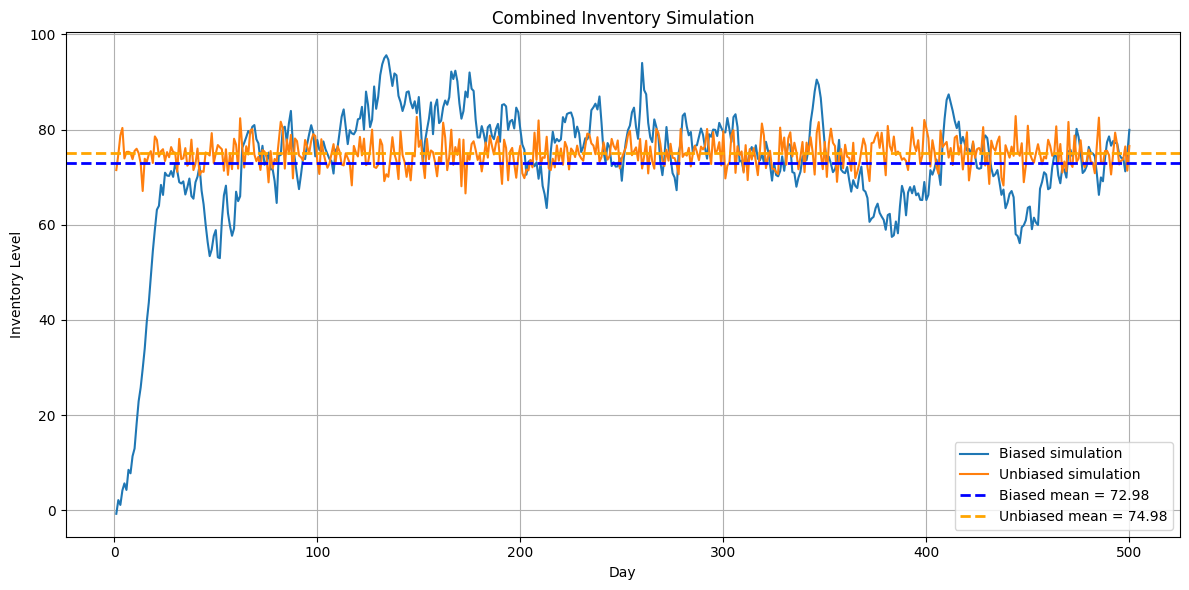


--- Analysis for Biased Inventory Simulation ---

ACF and PACF for Biased Inventory:


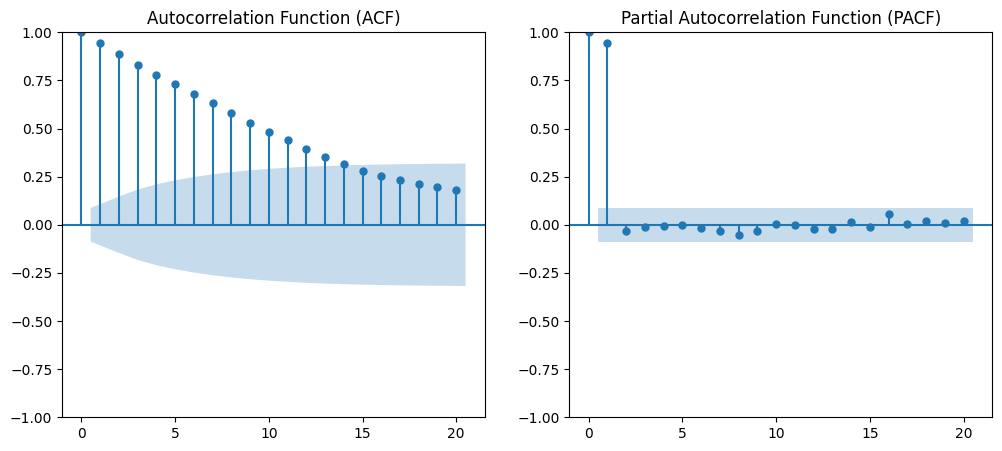

      lb_stat  lb_pvalue
5    3.241957   0.662739
10   8.486551   0.581423
15  14.843423   0.462754
Chosen AR order (p=3) is appropriate for biased inventory data.

Bias detection tests for Biased Inventory:
Method: detect_initialization_bias
The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
------------------------------------------------------------------------------------------------------------------------------------------------------
Method: test_initialization_bias
test_statistic: 6.414342069817628
decision: The null hypothesis is rejected, there exists statistically significant evidence of initialisation bias
stationary_mean: 75.05664333766606
stationary_std_dev: 7.34416282165537
effective_sample_size: 152
t_critical: 1.654940174705469
------------------------------------------------------------------------------------------------------------------------------------------------------
Method: transient_mean_test
Method: trans

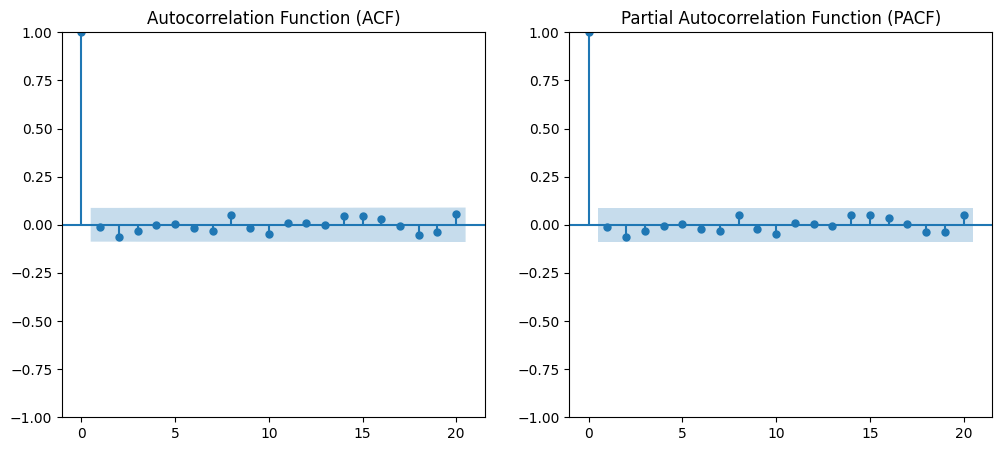

     lb_stat  lb_pvalue
5   0.490785   0.992457
10  3.525988   0.966209
15  5.821418   0.982594
Chosen AR order (p=2) is appropriate for less biased inventory data.

Bias detection tests for Less Biased Inventory:
Method: detect_initialization_bias
The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
------------------------------------------------------------------------------------------------------------------------------------------------------
Method: test_initialization_bias
test_statistic: -1.2377255860534404
decision: The null hypothesis is NOT rejected, the evidence for initialisation bias is insufficient to reach a conclusive determination
stationary_mean: 74.86707480648128
stationary_std_dev: 2.9847951142525213
effective_sample_size: 437
t_critical: 1.6483479614883643
-----------------------------------------------------------------------------------------------------------------------------------------

In [18]:
np.random.seed(328423)

# =============================================================================
# FUNCTIONS FOR INVENTORY SIMULATION
# =============================================================================

def simulate_inventory(n=200, growth_duration=30, phi=0.9, sigma=3.0, final_mean=75):
    """
    Simulates the evolution of the average inventory level with a growth phase followed by a stationary behavior

    Args:
        n (int): Total number of days
        growth_duration (int): Duration of the growth phase. If > 0, there is bias
        phi (float): Persistence coefficient for the stationary phase 
        sigma (float): Standard deviation of the noise
        final_mean (float): Stationary mean

    Returns:
        tuple: (y, theoretical_mean) where:
            - y: simulated series
            - theoretical_mean: vector of the theoretical mean (logistic for growth days and constant afterwards)
    """
    y = np.zeros(n)
    theoretical_mean = np.zeros(n)

    if growth_duration > 0:
        # Growth phase: logistic function with noise
        x = np.linspace(-4, 4, growth_duration)
        growth_curve = final_mean / (1 + np.exp(-x))
        y[:growth_duration] = growth_curve + np.random.normal(0, sigma/2, growth_duration)
        theoretical_mean[:growth_duration] = growth_curve
        # From growth_duration onwards, the process follows an AR dynamic
        y[growth_duration] = final_mean + np.random.normal(0, sigma)
        theoretical_mean[growth_duration] = final_mean
        for t in range(growth_duration + 1, n):
            y[t] = final_mean + phi * (y[t-1] - final_mean) + np.random.normal(0, sigma)
            theoretical_mean[t] = final_mean
    else:
        # No growth phase: process already in stationary state
        y = final_mean + np.random.normal(0, sigma, n)
        theoretical_mean[:] = final_mean

    return y, theoretical_mean


# =============================================================================
# SIMULATION AND COMBINED PLOT
# =============================================================================

# Simulation parameters
n_days = 500
batch_size = 50 
num_initial_batches = 5 

# Simulation with growth phase (with bias)
biased_inventory, theoretical_mean_biased = simulate_inventory(n=n_days, growth_duration=30, phi=0.9, sigma=3, final_mean=75)
# Simulation without growth phase (without bias)
less_biased_inventory, theoretical_mean_less_biased = simulate_inventory(n=n_days, growth_duration=0, phi=0.9, sigma=3, final_mean=75)

# Calculate the actual mean (sum of observations / number of observations)
biased_mean = np.mean(biased_inventory)
unbiased_mean = np.mean(less_biased_inventory)

# Create the combined plot
plt.figure(figsize=(12, 6))
observation_numbers = np.arange(1, n_days + 1)
plt.plot(observation_numbers, biased_inventory, label='Biased simulation')
plt.plot(observation_numbers, less_biased_inventory, label='Unbiased simulation')
plt.axhline(biased_mean, color='blue', linestyle='dashed', lw=2, label=f'Biased mean = {biased_mean:.2f}')
plt.axhline(unbiased_mean, color='orange', linestyle='dashed', lw=2, label=f'Unbiased mean = {unbiased_mean:.2f}')
plt.xlabel("Day")
plt.ylabel("Inventory Level")
plt.title("Combined Inventory Simulation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('final_example.png')
plt.show()


# --- Analysis for Biased Inventory Simulation ---
print("\n--- Analysis for Biased Inventory Simulation ---\n")

print("ACF and PACF for Biased Inventory:")
plot_acf_pacf(biased_inventory, lags=20)
p = 3
if correct_p(biased_inventory, p):
    print(f"Chosen AR order (p={p}) is appropriate for biased inventory data.")
else:
    print(f"Chosen AR order (p={p}) is NOT appropriate for biased inventory data.")

print("\nBias detection tests for Biased Inventory:")
print("Method: detect_initialization_bias")
p_value, result_str = detect_initialization_bias(data=biased_inventory, p=p, alpha=0.05)
print(result_str)
print("-"*150)

print("Method: test_initialization_bias")
result_dict = test_initialization_bias(biased_inventory, p, alpha=0.05, bias_type='neg')
for k, v in result_dict.items():
    print(f"{k}: {v}")
print("-"*150)

print("Method: transient_mean_test")
for method_index in range(0, 5):
    print(f"Method: transient_mean_test - {method_names[method_index]}:")
    result_dict = transient_mean_test(time_series=biased_inventory, batch_size=batch_size,
                                        num_initial_batches=num_initial_batches, alpha=0.05, method=method_index)
    for k, v in result_dict.items():
        print(f"{k}: {v}")
    print("-"*150)


# --- Inventory Simulation without Bias ---
print("=== Inventory Simulation WITHOUT BIAS ===")

print("\n--- Analysis for Less Biased Inventory Simulation ---\n")
print("ACF and PACF for Less Biased Inventory:")
plot_acf_pacf(less_biased_inventory, lags=20)
p = 2
if correct_p(less_biased_inventory, p):
    print(f"Chosen AR order (p={p}) is appropriate for less biased inventory data.")
else:
    print(f"Chosen AR order (p={p}) is NOT appropriate for less biased inventory data.")

print("\nBias detection tests for Less Biased Inventory:")
print("Method: detect_initialization_bias")
p_value, result_str = detect_initialization_bias(data=less_biased_inventory, p=p, alpha=0.05)
print(result_str)
print("-"*150)

print("Method: test_initialization_bias")
result_dict = test_initialization_bias(less_biased_inventory, p, alpha=0.05, bias_type='pos')
for k, v in result_dict.items():
    print(f"{k}: {v}")
print("-"*150)

print("Method: transient_mean_test")
for method_index in range(0, 5):
    print(f"Method: transient_mean_test - {method_names[method_index]}:")
    result_dict = transient_mean_test(time_series=less_biased_inventory, batch_size=batch_size,
                                        num_initial_batches=num_initial_batches, alpha=0.05, method=method_index)
    for k, v in result_dict.items():
        print(f"{k}: {v}")
    print("-"*150)

##### Results
<p style="text-align: justify;">
The <strong>Combined Inventory Simulation</strong> graph illustrates the simulated progression of the inventory level of a product in two scenarios: one characterised by an initial growth phase (blue curve) and one devoid of such a phase (orange curve). The blue dotted line denotes the average inventory level in the former scenario, while the orange line indicates the latter. Evidently, the initial growth phase exerts an influence on the average inventory value, which is lower than in the scenario devoid of such a phase. This demonstrates that initiating a system in a transitional phase introduces a bias into the estimation of the average inventory level.
</p>

- <Strong>Biased Simulation</Strong>
<p style="text-align: justify;"> 
The ACF plot on the left exhibits a slow decay in autocorrelation values as the lag increases, indicating that past values continue to influence future observations. This persistent autocorrelation suggests that the process retains memory, which is a characteristic feature of initialization bias. The PACF plot on the right shows a significant spike at the first lag, followed by values that quickly drop within the confidence interval, implying that the primary dependency is short-term. This behavior is typical of biased data, where an artificial trend introduced at the beginning of the time series generates spurious correlations that gradually dissipate over time.
 The statistical tests applied aim to detect the presence of initialization bias in the data. The majority of the methods confirm the presence of bias by rejecting the null hypothesis, indicating strong statistical evidence of initialization bias. The methods <em>detect_initialization_bias</em>, <em>test_initialization_bias</em>, and most of the <em>transient_mean_test</em> variants (BM, BM+Area, BM+Maximum) all return test statistics exceeding their respective critical values, leading to a rejection of the null hypothesis. This strongly suggests the presence of initialization bias.
 However, the <em>transient_mean_test - Area</em> method does not reject the null hypothesis, indicating that it does not provide conclusive evidence for bias. This inconsistency may be due to the specific assumptions or the sensitivity of this test. One possibility is that the Area metric does not effectively capture transient deviations, making it less responsive to initialization effects. Alternatively, it may be more robust to minor fluctuations but lacks the granularity needed to detect biases manifesting over shorter time frames. Despite this single exception, the overall results indicate a strong presence of initialization bias, as I expected.
</p>

- <Strong>Unbiased Simulation</Strong>
<p style="text-align: justify;"> 
The ACF plot on the left displays autocorrelation values that remain close to zero for all lags, without any evident structured decay. This behaviour suggests that past values do not significantly influence future observations, which is consistent with the absence of initialization bias. The PACF plot on the right confirms this observation: no significant spikes are noticeable beyond the first lag, and the values remain within the confidence interval, indicating the absence of spurious dependencies artificially introduced into the time series.
 The statistical tests conducted to detect the presence of initialisation bias support this interpretation, with none of the applied methods rejecting the null hypothesis. This suggests that there is no sufficient statistical evidence to assert the existence of bias. 
</p>

## Conclusion
<p style="text-align: justify;">
    In summary, this notebook presents a rigorous evaluation of three statistical methods—
    <code>detect_initialisation_bias</code>,
    <code>test_initialisation_bias</code>, and
    <code>transient_mean_tests</code>—for their effectiveness in identifying initialization bias in simulation output.
    Through benchmark examples and a final inventory simulation, the capability of these methods to discern between biased and unbiased simulation runs has been demonstrated.
    The tests generally aligned in their findings, successfully detecting bias in scenarios designed to exhibit it and confirming the absence of bias when expected.
    Notably, the inventory simulation highlighted the subtle nature of initialization bias and the importance of robust detection methods.
    While the <code>transient_mean_test - Area</code> method showed a slight inconsistency, the overall suite of tests provides a valuable toolkit for simulation practitioners.
    These methods offer a robust framework for assessing the reliability of simulation results by ensuring that outputs are not contaminated by transient effects, thereby enhancing the accuracy and credibility of simulation-based decision-making.
</p>
</section>

## References
*   **Schruben, L.W.** (1982). Detecting Initialization Bias in Simulation Output. *Operations Research*, *29*(1), 125-142.

*   **Schruben, L.W., Singh, H., & Tierney, L.** (1983). Optimal Tests for Initialization Bias in Simulation Output. *Operations Research*, *31*(6), 1167–1178.

*   **Goldsman, D., Schruben, L.W., & Swain, J.J.** (1994). Tests for Transient Means in Simulated Time Series. *Naval Research Logistics*, *41*(2), 171–187.
